# PubChem validation
This notebook demonstrates a new (?) idea in LBVS validation - pinging the pubchem server for assays for a given compound / target pair, and assessing the Outcome field. 

The main difficulty/novelty here is automating the approach while ensuring it gets the CORRECT assay. This is because many targets have different names, and there is no standard format for assay descriptions *or* outcomes.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
from pprint import pprint

import re

from tqdm import tqdm_notebook

import scipy
from scipy import sparse
from scipy import stats

import pubchempy as pcp
from chembl_webresource_client.new_client import new_client 
import json
import requests

import copy

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

import sys
sys.path.append("..")
import utils
import numpy as np

# Make some structure-predictions with label correlations:



In [2]:
#all labels:
interaction_matrix = sparse.load_npz('../0_data/interaction_matrix_pchembl.npz')
smiles = pd.read_csv('../0_data/pchembl_chemicals.csv')
targets_df= pd.read_csv('../0_data/subset_targets.csv')

uniprots = pd.read_csv('./uniprot_accessions.csv').drop_duplicates(['chembl_id', 'accession', 'pref_name'])
targets_df = targets_df.merge(uniprots, on=['chembl_id', 'pref_name']).drop(['year', 'canonical_smiles', 'lig_chemblid'],axis=1)



In [5]:
params = utils.read_params('hpo_lightfm_warp')

In [53]:
probability_matrix = utils.train_lightfm_warp(params, interaction_matrix)

In [54]:
train, test, fps = utils.load_time_split(year=2030, 
                                         return_fingerprints=True) #set a year after now to get ALL records

#now make all Known predictions very negative (so we don't sample them.)
labels_rows, labels_cols = interaction_matrix.nonzero()
probability_matrix[labels_rows,labels_cols] = -1e6

probability_arr = probability_matrix.copy()



In [55]:
##sort the predictions in order of probability, highest first. 

arr = probability_matrix#.toarray()
arr = arr - interaction_matrix
arr_sorted = np.dstack(np.unravel_index(np.argsort(-arr.ravel()), (arr.shape[0], arr.shape[1])))[0]
print('Should be a high number < 1:')
print(probability_arr[arr_sorted[0][0]][arr_sorted[0][1]])
print('Should be a low number >= 0:')
print(probability_arr[arr_sorted[-1][0]][arr_sorted[-1][1]])
print('Sorted array indices:')
arr_sorted

Should be a high number < 1:
13.239689826965332
Should be a low number >= 0:
-1000000.0
Sorted array indices:


array([[264415,     97],
       [329629,     97],
       [191545,     73],
       ...,
       [ 89493,     70],
       [306146,     87],
       [ 85026,    166]])

In [57]:
#sanity check - make sure the ligand IDX, smiles, and target IDX and target names line up:

for pair in arr_sorted[:10]:
    smi = smiles['canonical_smiles'].iloc[pair[0]]
    chembl_id = smiles['lig_chemblid'].iloc[pair[0]]
    predicted_target = targets_df['pref_name'].iloc[pair[1]]
    tid = targets_df[targets_df['pref_name']==predicted_target]['pref_name'].iloc[0]
    print(smi[:10]+'...', predicted_target, '\t', tid)
    print(chembl_id, smi)

Oc1cccc2cc... Acetylcholinesterase 	 Acetylcholinesterase
CHEMBL3901082 Oc1cccc2ccc(CN(CC#C)C(C#N)C3CCN(Cc4ccccc4)CC3)nc12
O=C(NCc1cc... Acetylcholinesterase 	 Acetylcholinesterase
CHEMBL492233 O=C(NCc1ccccc1)O[C@H]2CO[C@@H]3[C@@H](CO[C@H]23)OC(=O)\C=C\c4ccccc4
Cl.N[C@@H]... Monoamine oxidase B 	 Monoamine oxidase B
CHEMBL3416427 Cl.N[C@@H]1C[C@H]1c2ccc(NC(=O)c3ccccc3)cc2
CC(C)(C)c1... Acetylcholinesterase 	 Acetylcholinesterase
CHEMBL445192 CC(C)(C)c1ccccc1OC(=O)N2c3ccccc3Sc4ccccc24
CN(CCCCCCC... Acetylcholinesterase 	 Acetylcholinesterase
CHEMBL455790 CN(CCCCCCCOc1ccc(cc1)c2oc3ccccc3c2C(=O)c4ccc(C)cc4)Cc5ccccc5
CCOC(=O)c1... Sphingosine 1-phosphate receptor Edg-1 	 Sphingosine 1-phosphate receptor Edg-1
CHEMBL3655425 CCOC(=O)c1ccc2c(C(=O)NCc3ccc(F)c(F)c3)c(C(C)C)n(Cc4cccnc4)c2c1
Fc1ccc(cc1... Acetylcholinesterase 	 Acetylcholinesterase
CHEMBL2336428 Fc1ccc(cc1)c2nc(c3ccccc3)c(c4ccccc4)n2CCCCCCCCNc5c6CCCCc6nc7ccccc57
COc1ccc2[n... Acetylcholinesterase 	 Acetylcholinesterase
CHEMBL3824

# PubChem-pinging 

This became much cleaner when wrapped in a class. The below uses a class to perform a number of functions:

- save/load checkpoints - i.e. if something breaks, or you want to come back to this later after shutting the laptop, you can save all the data and load it afterwards to pick back up
- ping `pubchempy` for compound ID (CID) numbers.
- ping `chembl_webresource_client` for target synonyms
- ping pubchem REST API for assays associated with a CID
- records all of this stuff in dicts to be saved as JSON so I can parse it later. 

In [58]:
class PubChemValidator(object):
    def __init__(self, targets_df, smiles, interaction_matrix, fps):
        self.tdf = targets_df
        self.interaction_matrix = interaction_matrix
        self.fps = fps
        self.smiles = smiles

        self.ligands = {}
        self.targets = {}
        self.predictions = {}

    def load_checkpoint(self, ligands=True, targets=True, predictions=True):
        if ligands:
            self.ligands = json.load(open('ligands.json', 'r'))
        if targets:
            self.targets = json.load(open('targets.json', 'r'))
        if predictions:
            self.predictions = json.load(open('predictions.json', 'r'))

    def save_checkpoint(self, ligands=True, targets=True, predictions=True):
        with open('ligands.json', 'w') as fp:
            json.dump(self.ligands, fp, indent=4,)
        with open('targets.json', 'w') as fp:
            json.dump(self.targets, fp, indent=4,)
        with open('predictions.json', 'w') as fp:
            json.dump(self.predictions, fp, indent=4,)

    def has_ligand(self, idx):
        if str(idx) in self.ligands:
            if 'smi' in self.ligands[str(idx)]:
                return True
        return False


    def has_target(self, idx):
        return str(idx) in self.targets

    def has_prediction(self, l_idx, t_idx):
        return str(l_idx)+':'+str(t_idx) in self.predictions

    def create_prediction(self, l_idx, t_idx, prob):
        record = dict()
        record['prob'] = str(prob)
        nn = self.get_nnrank_of_target(l_idx, t_idx)
        record['nn'] = nn

        self.predictions[str(l_idx)+':'+str(t_idx)] = record

    def create_target(self, idx):
        self.targets[str(idx)] = dict()
        record = self.targets[str(idx)]

        pref_name = self.tdf['pref_name'].iloc[idx]
        tid = self.tdf[self.tdf['pref_name']==pref_name]['chembl_id'].iloc[0]
        accession = self.tdf[self.tdf['pref_name']==pref_name]['accession'].iloc[0]

        record['pref_name'] = pref_name
        record['tid'] = tid
        record['accession'] = accession

    def create_ligand(self, idx):
        self.ligands[str(idx)] = dict()
        record = self.ligands[str(idx)]

        smi = smiles['canonical_smiles'].iloc[idx]
        chemblid = smiles['lig_chemblid'].iloc[idx]
        cid = self.get_cid(smi)
        
        #now get active assays:
        aids = self.get_assays_given_cid(cid, activity='active')
        active_accessions = self.get_uniprot_accession_from_aid(aids)
        
        #now get inactive assays:
        aids = self.get_assays_given_cid(cid, activity='inactive')
        inactive_accessions = self.get_uniprot_accession_from_aid(aids)

        record['smi']=smi
        record['chemblid'] = chemblid
        record['cid'] = cid
        record['actives'] = active_accessions
        record['inactives'] = inactive_accessions
        
################################    
    def get_assays_given_cid(self, cid, activity='active'):
        url  = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/'
        url += str(cid)
        url += '/aids/JSON?aids_type='
        url += activity

        out = json.loads(requests.get(url).content)
        assay_ids = self.get_aids_from_pugrest_output(out)
        return assay_ids
    
    def get_uniprot_accession_from_aid(self, assay_ids):
        accession_dict = {}
        while len(assay_ids)>0:
            end = min(400, len(assay_ids))
            aids = assay_ids[:end]
            concat_aids = ','.join(aids)

            url  = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/assay/aid/'
            url += concat_aids
            url +='/targets/ProteinAccession/JSON'
            out = json.loads(requests.get(url).content)

            accessions = self.parse_accessions_from_pugrest_output(out)
            accession_dict = {**accession_dict, **accessions}

            assay_ids = assay_ids[end:]

        return accession_dict
    
    def get_aids_from_pugrest_output(self, output):
        assay_ids = []
        if 'InformationList' in output.keys():
            assay_ids += [str(i) for i in output['InformationList']['Information'][0]['AID']]
        return assay_ids

    def parse_accessions_from_pugrest_output(self, output):
        accessions = {}
        if 'InformationList' in output.keys():
            for aid in output['InformationList']['Information']:
                if 'ProteinAccession' in aid:
                    available_accessions = aid['ProteinAccession']
                    for accession in available_accessions:
                        if '_' not in accession:
                            accessions[aid['AID']] = accession
        return accessions


################################
    def get_cid(self, smi):
        try:
            c = pcp.get_compounds(smi, 'smiles')[0]
            return c.cid
        except Exception as e:
            print(e)
            return 'cid_failed'
    
    def get_nnrank_of_target(self, ligand_idx, target_idx):
        positives = self.interaction_matrix[ligand_idx].nonzero()[1]
        all_distances = self.fast_jaccard(self.fps[ligand_idx], self.fps)[0]
        s = np.argsort(all_distances)

        pred = target_idx
        curr_rank = 0
        count=1
        preds = []
        seen = []

        while pred not in seen:
            predictions = self.interaction_matrix[s[count]].nonzero()[1]
            preds = np.setdiff1d(predictions,positives)
            preds = np.setdiff1d(preds, seen)
            curr_rank = len(seen)
            seen += list(preds)
            if len(preds)>0:
                 curr_rank+= np.mean(np.arange(len(preds))+1)
            count+=1

        return curr_rank
    
    ##The following is to calculate AVE bias:
    def fast_jaccard(self, X, Y=None):
        """credit: https://stackoverflow.com/questions/32805916/compute-jaccard-distances-on-sparse-matrix"""
        if isinstance(X, np.ndarray):
            X = sparse.csr_matrix(X)
        if Y is None:
            Y = X
        else:
            if isinstance(Y, np.ndarray):
                Y = sparse.csr_matrix(Y)
        assert X.shape[1] == Y.shape[1]

        X = X.astype(bool).astype(int)
        Y = Y.astype(bool).astype(int)
        intersect = X.dot(Y.T)
        x_sum = X.sum(axis=1).A1
        y_sum = Y.sum(axis=1).A1
        xx, yy = np.meshgrid(x_sum, y_sum)
        union = ((xx + yy).T - intersect)
        return (1 - intersect / union).A

In [59]:

pcv = PubChemValidator(targets_df, smiles, interaction_matrix, fps)
#pcv.load_checkpoint()

# How many predictions to sample, and which ones?

Ideally we want to sample a good few predictions that have high probabilities. But we also want to see how well it performs at lower probabilities. The problem is that even sampling over the highest, say, 10,000,000 predictions will be highly biased toward lower probabilities! So we try to weight the random selection to balance it out, selection an even number of high- and low-scoring predictions.

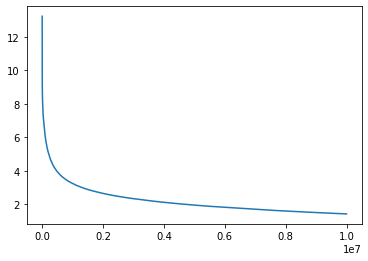

In [60]:
num = 10_000_000
probs = probability_arr[arr_sorted[:,0][:num], arr_sorted[:,1][:num]]
plt.plot(probs)

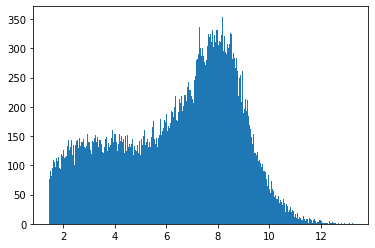

In [61]:
n = 10_000_000
take = 40000

weight = 1 / ((np.arange(n)**1.25)/(0.1*take)+1)
weight = weight/weight.sum()

sample = np.random.choice(n, take, p=weight, replace=False)

sample_arr = arr_sorted[sample]

_ = plt.hist(probability_arr[sample_arr[:,0][:num], sample_arr[:,1][:num]], bins=300)

# Do the sampling.


In [ ]:
import tqdm
for count, prediction in tqdm.tqdm_notebook(enumerate(arr_sorted[sample]), 
                                            total=10000,
                                           smoothing=0):
    print(prediction)
    ligand_idx = prediction[0]
    target_idx = prediction[1]
    probability = probability_arr[ligand_idx][target_idx]
    
    if not pcv.has_ligand(ligand_idx):
        pcv.create_ligand(ligand_idx)
       
    if not pcv.has_target(target_idx):
        pcv.create_target(target_idx)
        
    #if the ligand has any active or inactive assays, we will save them:
    actives = pcv.ligands[str(ligand_idx)]['actives']
    inactives = pcv.ligands[str(ligand_idx)]['inactives']
    if (len(actives) + len(inactives)) > 0:
        #then record the prediction:
        if not pcv.has_prediction(ligand_idx, target_idx):
            pcv.create_prediction(ligand_idx, target_idx, probability)

    if count>0 and count%100==0:
        pcv.save_checkpoint()



[248600    162]
[112359    104]
[253531     44]
[174165    124]
[32795    93]
[209494     73]
[322517    168]
[335551     97]
[306053    327]
[176312     97]
[207552    142]
[322237    121]
[186845    250]
[152060     34]
[283234    147]
[267113    173]
[352026     73]
[285771    143]
[103066    117]
[136163    154]
[317886     74]
[159975    178]
[354418    172]
[218701     74]
[259991     69]
[89288   174]
[250915     99]
[274614    122]
[217427    283]
[145380    174]
[99821   201]
[137609    138]
[55129   250]
[20000    77]
[325774    103]
[287284    250]
[558 114]
[149409    117]
[100742     84]
[253171    311]
[297472     40]
[321115     84]
[166162    228]
[234830    197]
[180418    211]
[150868    168]
[284912    133]
[27419   306]
[102183    138]
[130756    154]
[329618    129]
[257517    119]
[156698     47]
[302279     97]
[246426    191]
[278502    138]
[148550    168]
[285771    136]
[314939     90]
[86953   250]
[89723   256]
[109804    306]
[6051   82]
[138027    246]
[3

# Repeat:

In [41]:
n = 10_000_000
take = 40000

weight = 1 / ((np.arange(n)**1.25)/(0.1*take)+1)
weight = weight/weight.sum()

sample = np.random.choice(n, take, p=weight, replace=False)

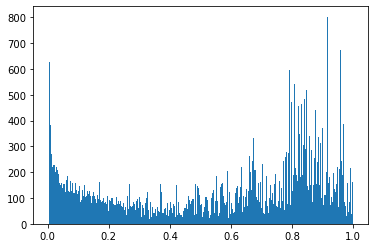

In [42]:
sample_arr = arr_sorted[sample]

_ = plt.hist(probability_arr[sample_arr[:,0][:num], sample_arr[:,1][:num]], bins=300)

In [43]:
for count, prediction in enumerate(arr_sorted[sample]):
    print(prediction)
    ligand_idx = prediction[0]
    target_idx = prediction[1]
    probability = probability_arr[ligand_idx][target_idx]
    
    try:
        if not pcv.has_ligand(ligand_idx):
            pcv.create_ligand(ligand_idx)
        
        if not pcv.has_target(target_idx):
            pcv.create_target(target_idx)
        
        if not pcv.has_prediction(ligand_idx, target_idx):
            pcv.create_prediction(ligand_idx, target_idx, probability)
        
    except KeyboardInterrupt:
        raise
    except Exception:
        pass
    
    if count>0 and count%50==0:
        pcv.save_checkpoint()

[160993     79]
[222898    138]
[282541    166]
[124436    112]
[329494     80]
[217403    166]
[124853     64]
[59797   165]
[66325    36]
[61895    52]
[256776    149]
[139052    166]
[119480    123]
[136030     91]
[254744     73]
[76887   170]
[20279   127]
[103424     52]
[250471    138]
[297563     91]
[67349   164]
[271335    116]
[292568    177]
[90983   144]
[258629     79]
[110862    177]
[1828    6]
[14787    33]
[35775   170]
[120106    146]
[232769     11]
[46110   109]
[104334    149]
[2185   88]
[68489    79]
[15417    73]
[127557    102]
[177910    208]
[277245    127]
[313916    171]
[225400    177]
[72994   214]
[156748    108]
[162909     52]
[320779    166]
[150545     76]
[315225     89]
[38825   170]
[273226     84]
[282874    136]
[256766    138]
[10720   166]
[327470    205]
[320918    180]
[39496    76]
[298116    105]
[90393    82]
[222007     88]
[316696     67]
[131588    142]
[222070    136]
[130797    166]
[150059    127]
[308056    162]
[318723      0]
[3

[214834    123]
[188792    149]
[146813     82]
[146411    214]
[197038    215]
[89896    90]
[217620    127]
[132373    127]
[239986    138]
[237625    166]
[215231     52]
[189249    132]
[107465    127]
[312587     84]
[333910    215]
[225123    177]
[67617   149]
[162636    149]
[72800   202]
[66584   142]
[145616    100]
[292147    162]
[121413     76]
[267372     76]
[67489   133]
[320606     90]
[160626     14]
[162907     52]
[89589   144]
[312630     52]
[173522    162]
[67756   224]
[242382     79]
[52311    94]
[153977    131]
[180917    237]
[337893     91]
[173803    233]
[68378   138]
[281966     99]
[133936    165]
[24062   177]
[276435    138]
[318949     15]
[287170     95]
[111480    177]
[185597    149]
[216712     83]
[331624     76]
[68181    75]
[320568     86]
[68886   177]
[216395     11]
[311031    177]
[69489   166]
[68335    79]
[28065   165]
[71696    90]
[56657   165]
[80146    84]
[65822   165]
[68780   177]
[91829    90]
[44529    95]
[48071    63]
[31104

[191165     11]
[314181    103]
[265391     48]
[217266     52]
[161157     31]
[57254    76]
[168340    177]
[10051    64]
[142735     86]
[42522   154]
[164342     52]
[76682   169]
[89896    71]
[227634    142]
[68544   138]
[269415    149]
[225074    169]
[76744    63]
[294628     88]
[331595     94]
[176113    175]
[58003   140]
[55585   165]
[63912   122]
[160543     52]
[99394   139]
[85996    86]
[279666    142]
[224592    165]
[275340    165]
[134219    139]
[225488     64]
[279925     52]
[110030    220]
[65886   199]
[160186     41]
[333696     94]
[52499   126]
[245271     99]
[26689   170]
[5386  222]
[157763    129]
[312432     71]
[32975   225]
[219391     71]
[234909     76]
[67253   215]
[228369    205]
[74620   118]
[250259    191]
[215789    138]
[77206    52]
[52184   230]
[65675   178]
[300071    122]
[58883   128]
[194546    120]
[254052     94]
[194570    138]
[292446     94]
[67021   103]
[81523    46]
[310061     52]
[25002   127]
[139473    127]
[293405    170

[29359    38]
[209194    138]
[310550     75]
[288342    132]
[62311    52]
[124749     79]
[131407     52]
[103409    127]
[45197   231]
[323920     90]
[66029   224]
[264747     86]
[43483    62]
[154195     90]
[128405    218]
[189945    214]
[127691    138]
[114946    103]
[293826    122]
[153740    127]
[271713    116]
[67814    36]
[314708    139]
[270179    149]
[143671    170]
[305248    166]
[234162    138]
[155370    127]
[331436    102]
[135871    138]
[11877    76]
[218047     99]
[329496    157]
[173278     86]
[68619   120]
[320434    113]
[132705     52]
[66143    73]
[315727     79]
[67617   138]
[180894    237]
[228367     84]
[133123    127]
[130035     72]
[54176    90]
[133124    127]
[280015    166]
[67665   128]
[103430     52]
[165097    164]
[38096    90]
[243037    102]
[153290     52]
[64955   116]
[123275     76]
[215581     52]
[39998   157]
[188797    149]
[66714   178]
[316020    144]
[248078    194]
[328420     38]
[66530   175]
[106029     99]
[76697   1

[171628     75]
[85371    98]
[9080   94]
[324073    155]
[27993   134]
[300232     62]
[217959    149]
[260351    149]
[148523    166]
[90927   104]
[56357    52]
[4355  147]
[20933    80]
[292908    170]
[279869      8]
[65952   120]
[314002     14]
[18844    64]
[211768    228]
[304184     76]
[17750    95]
[328515     88]
[66804   225]
[133127     52]
[335917     82]
[234262    123]
[119418     72]
[270258    178]
[152273    170]
[160538     52]
[82395    86]
[138903      8]
[124790    177]
[281455     14]
[308153     76]
[266252    166]
[48871   164]
[26669    52]
[283170    166]
[49985     0]
[2323  170]
[315150     91]
[16118   170]
[75761    84]
[202320     72]
[163701     76]
[315804    169]
[100223    149]
[38006    64]
[279312     14]
[68718    54]
[137675     95]
[35894   189]
[101886    162]
[272285     82]
[261741     13]
[15998   144]
[285693     35]
[204488    191]
[67594    72]
[9655   64]
[329044    202]
[153742     52]
[15376    70]
[57389   170]
[297930    138]
[114

[111370     32]
[274678    136]
[65964    84]
[234614     79]
[69675    71]
[159605    149]
[68271   224]
[40928    17]
[127567    102]
[171151    175]
[63307   113]
[283745     52]
[69495    32]
[328464     71]
[54305    95]
[73236   215]
[308556     76]
[139704    170]
[222137    119]
[216790     52]
[293514     83]
[71208   180]
[123 191]
[2352  141]
[297256     98]
[28014    31]
[111478    177]
[87183   108]
[318084     10]
[66108   138]
[42852   139]
[39988   138]
[66652   205]
[141659    116]
[68038   205]
[316492     76]
[305625    166]
[278432    132]
[283874    215]
[336937     76]
[324279     84]
[245875    159]
[225066    177]
[67478   222]
[221383     72]
[61267   167]
[312846     76]
[299913    128]
[320406    224]
[66351   138]
[150050    127]
[121890     14]
[56720    76]
[281299    177]
[35391   127]
[84318    57]
[164394    119]
[66305    72]
[89118   215]
[146044    215]
[194526    138]
[160504    194]
[269931    199]
[215218    177]
[178724    215]
[276556    148]
[1

[41871   170]
[110854    177]
[92173   123]
[67914   150]
[178541    158]
[67664   215]
[83349   164]
[4433   90]
[297873     52]
[98256    98]
[68356   224]
[104823    149]
[72567    90]
[274993     91]
[870 177]
[115639    202]
[18253    64]
[145270    127]
[78302   199]
[46156    93]
[155119    166]
[317146     63]
[156516    131]
[337467    170]
[198958    123]
[123748    177]
[305854    170]
[255351    120]
[37045   224]
[233984    116]
[300301    138]
[163826    158]
[200607    178]
[193850     73]
[126222     98]
[159645    222]
[67082   215]
[8957   95]
[157500     83]
[310264    164]
[196807    155]
[123154     76]
[56538    33]
[67605   224]
[93394   165]
[119322    165]
[69410   113]
[292392     98]
[240130    138]
[96100   164]
[49948   122]
[246815     73]
[306192    225]
[152668    116]
[160360    178]
[66418   138]
[26828   170]
[327398    103]
[135992    170]
[260906      6]
[333971     82]
[190775    169]
[109882    149]
[131407    127]
[66171   142]
[185615    149]
[1

[294051     76]
[14595    19]
[124256     83]
[214210     95]
[84381   149]
[83019   139]
[66896   191]
[160716     52]
[307452     95]
[101608     52]
[237995     86]
[114053    116]
[202319     72]
[90148   149]
[270121    138]
[277040     64]
[238912    131]
[115351     80]
[14033   224]
[25257   162]
[211840    233]
[156338     76]
[295204    170]
[256198    183]
[223907    177]
[278830     72]
[140605     52]
[117391    100]
[97834    52]
[148499     11]
[265840    218]
[226554    142]
[94926   134]
[117217     98]
[120479     76]
[275130    166]
[289250    178]
[118829    205]
[144572     14]
[209182    178]
[191386    191]
[292161    116]
[283954    127]
[111482    177]
[308345    145]
[279737     73]
[324358    169]
[262637    138]
[327860    103]
[117369    122]
[276420     52]
[308595     75]
[188487    149]
[165567     52]
[82161    84]
[51956    86]
[294902    169]
[183515    166]
[14332    98]
[217807    165]
[245658    214]
[68046   224]
[200354     14]
[142583    123]
[6

[280156    225]
[92119    75]
[36778    18]
[148285     84]
[20414   116]
[260953     88]
[315397    177]
[145643     76]
[6164   88]
[138422     83]
[94540   116]
[5792  192]
[40506   136]
[255908     76]
[225606    204]
[217908    127]
[262631     72]
[136783     98]
[185611    149]
[278088    139]
[36792    86]
[311049    138]
[147901    127]
[111439     76]
[329424     16]
[321021     70]
[66663    36]
[314938    116]
[79443   138]
[230452    123]
[68365   100]
[48591    14]
[239571    215]
[140613     52]
[46782    99]
[311329     82]
[66262   183]
[216259     52]
[166211     30]
[96098    73]
[122522     63]
[201737    199]
[320130     67]
[66513   183]
[54518   160]
[256670     36]
[63420    94]
[56392    52]
[309543     67]
[99591   165]
[108053     84]
[188496    149]
[220518    218]
[120570     71]
[252011     72]
[103728    214]
[223185    178]
[118642    166]
[66982   202]
[183266    233]
[3440  142]
[336180    102]
[49782   169]
[245492    214]
[155625    142]
[209193    1

[47408    93]
[226206    215]
[305341     72]
[157699     83]
[68616   131]
[60494   172]
[320348     90]
[90477    94]
[105330     88]
[49784   169]
[17963   171]
[319826    103]
[326668      9]
[273944    136]
[277447     88]
[82919    88]
[66021    24]
[155366    127]
[328956    170]
[188805    149]
[48303   138]
[129655    194]
[224196    170]
[176489    199]
[173029    136]
[70866   140]
[151137    149]
[66748   149]
[319883    128]
[142968    127]
[15443    90]
[171155     29]
[171143     36]
[159503    177]
[280239    225]
[167080    121]
[16236   215]
[66020   202]
[113556     16]
[99122   165]
[1701  102]
[41088   122]
[22914   191]
[219246     88]
[1251   70]
[76689   141]
[24690    83]
[126960     84]
[278760      0]
[187650    138]
[45370   170]
[43388   177]
[333176    127]
[205030    100]
[188592    214]
[68093    13]
[67064   224]
[210039      0]
[125255    138]
[92477    13]
[35067   170]
[115608    178]
[217399    171]
[6431   48]
[309888     84]
[79908   122]
[71217  

[703  25]
[309663    103]
[68214   150]
[67496    29]
[126975     42]
[254755     14]
[209169    136]
[22613   194]
[92767    71]
[169694     51]
[185608    149]
[104814    149]
[122918    127]
[295848    127]
[67192   199]
[5547  178]
[156304     70]
[67069    36]
[222357    126]
[49386    11]
[132706    127]
[61059    99]
[161049    194]
[246242     72]
[178185    161]
[37391    46]
[157542    162]
[10436   127]
[97861   171]
[79805    52]
[66317    79]
[104489    141]
[240588    237]
[176515    178]
[74322   118]
[152669     18]
[37958    52]
[5456  103]
[19700    18]
[61973    57]
[248506    194]
[11189   138]
[253475    215]
[65228   127]
[79384    90]
[295971    170]
[67124    48]
[156575    127]
[279754    138]
[69408    35]
[209806    150]
[169325    191]
[190691     79]
[154547    225]
[83815   133]
[163240      8]
[105719     84]
[160711     52]
[14967    84]
[320335      6]
[81231    84]
[194529    138]
[140172     82]
[257501    158]
[133120     52]
[76133    64]
[85218   1

[93572   139]
[209193    138]
[133123     52]
[303138    123]
[155875    170]
[87913    37]
[240422     73]
[73427    98]
[265186    233]
[82122   164]
[194573    236]
[278384    178]
[177798     73]
[314054     84]
[110853     52]
[233868    154]
[217115    116]
[221040    138]
[78822   194]
[332298     91]
[57674   165]
[190657    205]
[175195    138]
[335429     82]
[98301   164]
[118157    100]
[154321    138]
[253189    199]
[332183     94]
[118185     67]
[66468   136]
[95516   231]
[107452    165]
[38249   116]
[104998    149]
[190142    214]
[65630   154]
[9839   94]
[60348    48]
[329966    162]
[16997    48]
[271115    178]
[79000   116]
[107315    165]
[54766   142]
[147584    177]
[166529     36]
[56378    82]
[67618    11]
[264947    199]
[194538    138]
[227313    196]
[68918   113]
[68371   142]
[61203   144]
[286808    214]
[93100   116]
[135380    116]
[58232   215]
[66368   185]
[60062   125]
[116847    122]
[291227    170]
[117587     99]
[107504    166]
[117541    1

[98983   127]
[54401   162]
[40065   224]
[197367    188]
[152115    214]
[50034   237]
[91913   149]
[263420    136]
[65998   131]
[296534      8]
[66094    31]
[140581     17]
[275449    102]
[262593    102]
[2674  102]
[68000   149]
[194496    138]
[134503    100]
[225367    177]
[292549    170]
[173266    132]
[184753     13]
[67448   237]
[194579    191]
[158956      6]
[15180    71]
[169161    116]
[320401     90]
[297494     84]
[303419    136]
[259511    237]
[239398     32]
[72030    98]
[140332     94]
[68422   199]
[295292    155]
[212166    165]
[221321     76]
[161698     74]
[84381   142]
[40535   177]
[169335    180]
[83188   167]
[281221    127]
[257278    233]
[63895    90]
[74193   139]
[295618    177]
[105720     76]
[278802     52]
[119951     78]
[148282     84]
[38470    95]
[109956     90]
[311057     82]
[313311     90]
[133136     52]
[107549     52]
[299805    103]
[11292    13]
[121659    105]
[286542    132]
[154737    127]
[234798     84]
[105733    165]
[3

[53427    31]
[215059    224]
[159782    185]
[309176     72]
[63811    91]
[192073    192]
[191382    138]
[166939     79]
[214903    180]
[97834   127]
[120550     98]
[139884    139]
[65230    52]
[77929   224]
[131244    170]
[267013    166]
[42517   170]
[213334     78]
[215965     86]
[307893     72]
[297015     53]
[230095     84]
[143127    162]
[170079    159]
[291135     88]
[58267   194]
[13376    33]
[176212    233]
[311271    224]
[248891    204]
[136698    102]
[313468     18]
[164343    127]
[148 128]
[67160   214]
[67448    73]
[163415    127]
[66080   224]
[28828   108]
[3914  149]
[291975    177]
[40670   171]
[66675   164]
[65231    52]
[310721     95]
[57586   165]
[191376    191]
[222258    158]
[67570   123]
[252474    199]
[320394     90]
[44629   121]
[335303    139]
[319624    169]
[75044    72]
[1008  128]
[27987   160]
[37858   158]
[334862    146]
[233592    127]
[95890    52]
[295095     70]
[65223   127]
[315340     64]
[67174   142]
[57369   222]
[77210  

[255747    138]
[129414    177]
[65980   205]
[325814     88]
[12678    62]
[97990   131]
[178084    214]
[9905   90]
[75901    71]
[121091    100]
[252848     76]
[116594     72]
[55530   147]
[156574    127]
[137390      6]
[225389    177]
[287387     88]
[135186    116]
[173559    149]
[311049    180]
[60296   194]
[109907    123]
[16619    16]
[316330    111]
[143725     98]
[272659    141]
[194542    138]
[92173    89]
[272892    123]
[117189    116]
[279635    165]
[251288     14]
[261206    224]
[48540   122]
[235993     49]
[142974    127]
[44803   172]
[68070   205]
[69159    13]
[160606     14]
[301473     68]
[247934     52]
[127241    139]
[223822     48]
[117621     53]
[156570    127]
[37773    90]
[167583     13]
[2515   88]
[273309     14]
[96654    95]
[320011     76]
[67551   149]
[136604     34]
[331724     29]
[332678    220]
[124510     91]
[33547    76]
[275101     56]
[57739   165]
[219824    138]
[324369     84]
[323156     84]
[132569    127]
[260543    138]
[1

[29026   104]
[282914    136]
[32002    98]
[250617    149]
[275863    177]
[32628   225]
[284381    148]
[132702    127]
[66815   131]
[127881     13]
[133135     52]
[187259    176]
[197332    199]
[194541    191]
[21335   157]
[73020    73]
[46773   126]
[307648    164]
[295992    139]
[142714     71]
[99183    52]
[52670   214]
[332091     86]
[281992    149]
[119618     84]
[3267   36]
[261117     73]
[67618   215]
[83914    52]
[158586    169]
[62780   136]
[302193     88]
[256192     79]
[144574     14]
[194009    150]
[129526    177]
[165108    105]
[4534   31]
[108590     14]
[81176    95]
[322804     90]
[133643     48]
[175114    138]
[286846     86]
[66982   191]
[101627     84]
[21424    76]
[194578    138]
[182925    133]
[246501     72]
[270590    189]
[78566   126]
[273226     71]
[30955    95]
[116584    192]
[306518    161]
[128511     98]
[320341     90]
[99593   127]
[79830    83]
[41698   178]
[2656  175]
[67970   150]
[36585   149]
[178157    144]
[330871     90]


[29448    40]
[322756    138]
[63228    91]
[309630     82]
[194304    167]
[243296     46]
[85353    98]
[225593     76]
[336075    138]
[297218    170]
[66273    38]
[263754    120]
[332739    179]
[316729     86]
[68200    88]
[294641    224]
[144569     14]
[145158     82]
[204465    191]
[236491    237]
[36284    71]
[194514    191]
[49591   169]
[65952   150]
[140612    127]
[321063      9]
[15947   159]
[180962    237]
[305639    215]
[133121     52]
[58487   233]
[2480   36]
[314443    174]
[313802    138]
[130466    170]
[223667    103]
[14489    76]
[187554    228]
[242867    169]
[160963     71]
[295938    150]
[331535    170]
[117580    224]
[167498    100]
[275670    161]
[232946    105]
[263801    180]
[133135    127]
[100534    161]
[301515     94]
[49514   116]
[264480    142]
[286144     79]
[164122     34]
[95978   224]
[322559    128]
[262264     48]
[316291     76]
[113238     11]
[73148   123]
[322559    164]
[141631     95]
[70153    88]
[11021   160]
[75482   144

[126764    112]
[140896    170]
[3979  169]
[178062     40]
[125453     83]
[199986    164]
[153505    177]
[158566    136]
[78314    64]
[33330   134]
[252315    155]
[265279     98]
[9170   83]
[330679      9]
[123233    141]
[126939    169]
[67806   215]
[312151    222]
[106980     54]
[36591   149]
[90128   149]
[161184    194]
[39436   122]
[276711    177]
[93034    62]
[332975    170]
[258475     73]
[178238    161]
[242676    138]
[312008    215]
[210567     73]
[336446    170]
[175918    159]
[46237   108]
[75341   164]
[46837   103]
[66470   149]
[270951    191]
[108301     36]
[295243    136]
[299604    104]
[315965     70]
[239381    233]
[325691     72]
[157500     91]
[323298     86]
[76210    79]
[194553    191]
[217635    127]
[116684    165]
[3092  188]
[188461    149]
[206153     98]
[66020    13]
[71869    31]
[142759    139]
[10778    90]
[91971   116]
[67798    79]
[73144    90]
[148196    222]
[77530   202]
[157382    103]
[226469    127]
[89011   116]
[9479  136]


[320652     98]
[254388     36]
[51404    82]
[59899    27]
[287798    224]
[36782    84]
[647  67]
[269218    222]
[265989    191]
[160124    108]
[237445    166]
[67998   149]
[100320    141]
[170111    159]
[150320    166]
[146822     82]
[300611     67]
[314904    224]
[136728     93]
[122911     88]
[147942    127]
[32315   165]
[103845    167]
[188164    108]
[29431    83]
[51291   139]
[315761    162]
[214813     15]
[102020     14]
[117022     76]
[133128     52]
[334144    102]
[165910    165]
[10428   170]
[94294    95]
[282077    149]
[72991    79]
[227428     13]
[82122    36]
[40002   218]
[226191    127]
[84186    90]
[256670    138]
[115079    165]
[103530    220]
[66535    29]
[74407   127]
[227983    228]
[217342    102]
[144383     54]
[152308     31]
[19344    95]
[192991    131]
[203606    149]
[68981   128]
[290780    215]
[275227     52]
[238897    233]
[67146    88]
[66440   142]
[72870    95]
[94488    71]
[150543     76]
[68473   224]
[280259    116]
[261809   

[60426    48]
[185601    149]
[11027   122]
[62836   138]
[37886   159]
[279309     98]
[107329    166]
[134790     76]
[45557    84]
[66451   224]
[311590    194]
[280277    194]
[283701    136]
[99699   165]
[125258     83]
[37957   177]
[12488   139]
[203490    194]
[271223     90]
[6485  158]
[72164    82]
[75663    71]
[94262   104]
[279863     90]
[243535    199]
[325845     81]
[107154    149]
[164638     71]
[209186    178]
[336075     11]
[15416   154]
[316905    141]
[275815    166]
[1782   98]
[64009    15]
[253403    222]
[156520     13]
[163689     86]
[280710    138]
[301552     94]
[274660    158]
[67584   215]
[191381    138]
[190906     73]
[277198    225]
[150609     71]
[84305   212]
[228122     16]
[272444    116]
[123266    116]
[127656     90]
[93672   205]
[159514    177]
[129403     17]
[106892     11]
[88145   123]
[249108    191]
[329928    162]
[152111     48]
[153682     76]
[81733     9]
[67454   142]
[159431     93]
[45409    83]
[42928    67]
[300519    2

[12647    98]
[322079    128]
[116686    103]
[207911    149]
[87546   129]
[76409   138]
[146045    215]
[308138     72]
[200266    158]
[281043    191]
[280375    127]
[12252   138]
[337539    177]
[310963    170]
[310634     72]
[327632    178]
[307287    192]
[295597    224]
[131876     73]
[123465     75]
[310923    121]
[83336   138]
[217060    127]
[200894     40]
[133843    102]
[297173     38]
[75374   140]
[27897   225]
[333112    123]
[173842    233]
[15255   138]
[263900    224]
[329496    236]
[227195    141]
[260275    169]
[272913    179]
[67452   202]
[286264     73]
[68021   138]
[316871    141]
[130473    127]
[68145   215]
[204478     79]
[220916    122]
[224807     29]
[318496    149]
[230588     98]
[263801    175]
[324366    215]
[109950    103]
[272657    116]
[202984     70]
[114467    220]
[43196   108]
[262403     90]
[290507    183]
[103090    175]
[173061    128]
[56497   198]
[192133     48]
[152406     52]
[281465    149]
[234729    149]
[275602    103]
[9

[50436    79]
[306660     49]
[68468   136]
[334862     98]
[78810   194]
[85997    76]
[314213     81]
[160715    127]
[66483   140]
[217341     94]
[153743    127]
[2556   16]
[147161     13]
[61873   138]
[185919     36]
[2757   62]
[294629    122]
[321722    128]
[319592    215]
[337744     76]
[10184    22]
[330228    224]
[117988     88]
[24042    54]
[142712     38]
[66873    73]
[228327    136]
[306563    122]
[222204    178]
[41634   127]
[68545    75]
[279914      9]
[111473    177]
[139115    112]
[103614    129]
[99081    95]
[107327      8]
[59825   165]
[282874    138]
[273378    139]
[120461     89]
[45429    83]
[989  94]
[40003   138]
[98102   165]
[187418    167]
[67947   150]
[311723     32]
[68616    48]
[38463   142]
[88118    84]
[323264     82]
[55118   178]
[15856   170]
[155917      8]
[3644  214]
[224642     48]
[235885    198]
[167821    164]
[154776    177]
[300746    105]
[68343   116]
[308276     83]
[322980    138]
[305761     98]
[310566     88]
[255025 

[92464   170]
[170758    133]
[51867   100]
[66542   175]
[183502     32]
[116696    116]
[86907   214]
[67988    95]
[68571   205]
[177141    165]
[314025     84]
[36267    76]
[269068    123]
[132043    127]
[173523    139]
[107124    116]
[16497   169]
[129288    141]
[90407    79]
[135561     54]
[76685   141]
[45035   204]
[66866   161]
[119039    102]
[20634   218]
[74114    64]
[1450  160]
[61657   192]
[119596    100]
[152030    175]
[82693    73]
[176518    178]
[157319    170]
[277504      8]
[14386   113]
[225172    141]
[160618    161]
[57883   128]
[51150    14]
[66604   150]
[307954    103]
[277363    162]
[62235   170]
[325413    119]
[2158   62]
[319131     88]
[107464    127]
[332325     53]
[92424    99]
[85856   214]
[70826    76]
[134013    165]
[92929    94]
[246848    134]
[40682    68]
[110848    127]
[242063     73]
[105043    149]
[109894     89]
[67289   150]
[226772    119]
[279425    166]
[68534   215]
[117183     36]
[275076    105]
[15613   139]
[85562   1

[87493    98]
[281616    100]
[211761    228]
[17495    84]
[36234    98]
[120365     36]
[3984  169]
[16603   170]
[320706    136]
[67609   215]
[66801   154]
[295640    136]
[123454    178]
[63572   177]
[68468   215]
[171137    149]
[332386     30]
[239083    102]
[220216     80]
[268385    205]
[138336     71]
[66880   155]
[277662    162]
[301488     88]
[321588    127]
[156209    166]
[67057   150]
[148481     36]
[300622     90]
[10566   224]
[156578     52]
[250400     89]
[112641    215]
[44989   128]
[73924   122]
[219977    192]
[72797   131]
[148060     86]
[221815    178]
[110323     28]
[85384   194]
[40825    76]
[176093    138]
[109204    149]
[73498   104]
[3275   99]
[299202     70]
[160024     18]
[76608   194]
[243917    233]
[151031    149]
[331503    165]
[207904     73]
[230491    166]
[125377     83]
[175397     36]
[252116    149]
[308945    169]
[120433     46]
[96132   158]
[250636     11]
[333538     52]
[200922    178]
[281476    122]
[207324     14]
[74125

[66128   120]
[313089    155]
[160360     73]
[107320     14]
[10428   179]
[303420     79]
[241026    123]
[306849     38]
[294218     75]
[274462     95]
[304260    133]
[259326    194]
[56130     6]
[161001     79]
[4475   41]
[168960    154]
[210561     73]
[29515    72]
[301730     88]
[1044   98]
[133785    194]
[33324   225]
[120516     38]
[12311   138]
[328903    158]
[66849   136]
[26637   112]
[162684     29]
[167733    164]
[331382     94]
[62935    81]
[301230     87]
[273001    158]
[261608     68]
[69700    98]
[45419    86]
[317567     67]
[310602    104]
[287598    128]
[194556    191]
[156583    196]
[240942     80]
[66884    75]
[67720   162]
[67897   202]
[78868   121]
[337512    170]
[42321   225]
[160602     14]
[205257    138]
[249567    194]
[109529    165]
[312063     11]
[141366     18]
[330758    127]
[103685    163]
[222663     75]
[89013    53]
[90152   149]
[135379     38]
[263123    102]
[39887   149]
[276225    103]
[259282     14]
[116079     82]
[66155

[217544    165]
[206589     15]
[202084    154]
[283456     73]
[237357    225]
[45013   180]
[16978    48]
[30006   162]
[196413    215]
[79059   127]
[150541     76]
[173265    185]
[188804    149]
[223697     86]
[117626     50]
[58254   194]
[174170    228]
[41761   198]
[126931     70]
[215739     99]
[269355    123]
[230744    158]
[252570     40]
[322482    138]
[250396     48]
[130586    194]
[184518    149]
[68534   214]
[67814   123]
[74265   129]
[327546     98]
[155424      6]
[80089   154]
[67538   218]
[131586    175]
[213126    193]
[67591   154]
[32490   139]
[309248     67]
[299412    130]
[67871   165]
[68021    89]
[86367    90]
[107460    127]
[80582    99]
[242224    224]
[14969    71]
[130652    199]
[26224   170]
[333280    220]
[328829     91]
[23164   225]
[68296   138]
[248237     79]
[136320    165]
[193960    178]
[192071    104]
[123304    176]
[231647    237]
[28237   177]
[70228   230]
[133309     70]
[308605     72]
[198439     72]
[94864    99]
[262351 

[66110   236]
[151816    105]
[146048    215]
[178313     16]
[66162   140]
[311308    103]
[241040     32]
[333179    214]
[222227     98]
[301386    199]
[308811    178]
[26450   165]
[275301     59]
[324402     48]
[322257    127]
[29646   139]
[106353    100]
[73668    64]
[66021   120]
[35880    16]
[162711    170]
[139336    138]
[66513   149]
[301956    177]
[160848     30]
[73346   105]
[34308   127]
[329406    122]
[66325    16]
[36266    76]
[284344     31]
[124459     91]
[329797     95]
[146146      9]
[159928     33]
[246517    180]
[289976    215]
[263052    144]
[220131     57]
[66970    13]
[278648    136]
[191380    191]
[14857   176]
[127094    170]
[98528   180]
[2825  237]
[3782   84]
[275648     71]
[246820      6]
[214460     34]
[15648   165]
[311049     36]
[190902    142]
[192986    154]
[244802     48]
[65982    90]
[332296    141]
[176295    178]
[133136    127]
[322139    150]
[298329    160]
[142627      9]
[277482    177]
[193228    170]
[334350    134]
[1

[316726    236]
[18804   170]
[131596    149]
[167772    178]
[226586    185]
[6250  158]
[68367   138]
[336351     76]
[24890   165]
[63985   167]
[72981    90]
[194528    138]
[30090   225]
[266359    168]
[232026     84]
[305931     19]
[172238    167]
[59172    56]
[147588    154]
[12480    71]
[13730    71]
[260918     29]
[62074   113]
[275231    112]
[116876    101]
[289208    154]
[206855     80]
[221904    116]
[172524     76]
[68514   215]
[327816    150]
[136589    103]
[286393    149]
[141974     29]
[156568    127]
[5440  127]
[223394    161]
[183963     80]
[145257    127]
[8604  209]
[52269    70]
[291638     82]
[264605    233]
[126899    140]
[238809     14]
[21199    73]
[330047     93]
[258775     76]
[278728    199]
[57289    76]
[287668     36]
[1858   99]
[172132    144]
[145652     76]
[13056   177]
[20768   123]
[67372   180]
[139452     11]
[296433    220]
[45424    83]
[87086   166]
[240464    149]
[287283     36]
[67780   136]
[44677    88]
[187359    159]
[2

[285997    123]
[104816    149]
[331178    102]
[116483     94]
[68116   141]
[336342    162]
[103721     11]
[19167    98]
[241998    138]
[326999    103]
[184133    215]
[278603     56]
[261815    133]
[247232    128]
[253721     76]
[110003    191]
[67085    11]
[305884     84]
[190795    162]
[319697     20]
[66982   183]
[178290     36]
[183148    233]
[166320     98]
[243225    237]
[211515     31]
[158571    111]
[50880   158]
[127887    136]
[255713    149]
[158210    177]
[300346     31]
[337470    170]
[8361    8]
[58252   158]
[273226     98]
[324813     76]
[264742    138]
[56853   154]
[82265   172]
[292220    162]
[90595   123]
[21200   204]
[92789    95]
[271575    179]
[281026    116]
[90122    75]
[279003    162]
[265271    102]
[94125    16]
[256103     27]
[114317    166]
[145707     82]
[132656    194]
[116257     76]
[58213    75]
[211966    125]
[213189    147]
[250984     72]
[226968      9]
[284835    214]
[173763    233]
[304324    103]
[66765   205]
[274983   

[202809    205]
[327151      9]
[143274    131]
[307880     98]
[158872    127]
[227924    205]
[100912    113]
[285435     13]
[136572    177]
[32884   166]
[215042     99]
[115316    161]
[317326     86]
[77208   165]
[305254    166]
[140287    198]
[90738   165]
[67688    36]
[222582     91]
[98155    84]
[99750   155]
[234156     73]
[67152    31]
[329228    100]
[251722    138]
[110238     91]
[150684    170]
[22576   225]
[80724   116]
[333109     76]
[114557     82]
[11994   141]
[111975    103]
[54768   142]
[98278   214]
[48629   191]
[37693    84]
[134045    177]
[100849    131]
[10281    52]
[63389    91]
[185775    165]
[261136     89]
[278451     98]
[68038   191]
[261500     90]
[337400    189]
[219920    126]
[11470   149]
[125097     95]
[45033   138]
[324170     95]
[72164    90]
[198041     89]
[111667    131]
[326011    127]
[167167    149]
[332126     71]
[20126   149]
[7379  166]
[314387     14]
[127893    138]
[100389    104]
[67698   164]
[33016   100]
[273310   

[23310    54]
[76210   142]
[281508    132]
[324668    162]
[62336   123]
[205555    197]
[133290    224]
[287922    214]
[51703   127]
[200604    138]
[298214    169]
[67950   202]
[20773   122]
[94324   178]
[81571   116]
[169526     91]
[67241   224]
[164932     14]
[300811    166]
[295699     83]
[144523    116]
[321517    142]
[23062    38]
[117333     88]
[113787    148]
[88138   150]
[294083     13]
[221367     76]
[8955  131]
[66348   215]
[304975    212]
[253430    183]
[203978    198]
[59820   239]
[333036    141]
[74408    52]
[80976    31]
[300172     76]
[295533     22]
[333750    170]
[254463    193]
[271127      6]
[226923    127]
[14369   113]
[222291    138]
[184511    199]
[332552      6]
[107421     95]
[121520     51]
[190799    162]
[336477     38]
[273704    103]
[327369     90]
[172955     31]
[56310    33]
[335403    162]
[298547    170]
[71518    68]
[126023    196]
[205545    104]
[60946   165]
[117581     99]
[31904    70]
[273198     11]
[98595   166]
[14277

[272323    116]
[62685    17]
[75756    84]
[157623     76]
[69524    79]
[98294   194]
[66701    31]
[220650     98]
[227358    136]
[166540    103]
[210868    222]
[126941      9]
[97820    84]
[274185     94]
[307001    121]
[16900    91]
[266048    155]
[143619    177]
[101475     52]
[258270    158]
[67152    36]
[222135    138]
[55902   178]
[126877    139]
[20110   203]
[221179    138]
[106624     88]
[136513    146]
[36319    71]
[111509    102]
[115896    121]
[222337     64]
[145161     86]
[212108     62]
[46142    98]
[48281    76]
[99090    82]
[123167     83]
[68403   123]
[322893     25]
[262382    199]
[64095    33]
[266239     76]
[104879    129]
[333858     76]
[169145    233]
[331000     48]
[304506    144]
[33737    15]
[23510   154]
[300809    142]
[116357    138]
[113926    185]
[230330    158]
[115252     32]
[127473    102]
[259558    169]
[139467    177]
[81072     9]
[249332    161]
[237625     14]
[61100   170]
[27753    98]
[75186   116]
[187586     89]
[685

[94763   160]
[113187    149]
[213597     76]
[7997  158]
[309114    180]
[113348     13]
[19749   220]
[68004   215]
[39426   122]
[42738   225]
[291639     90]
[43913   119]
[219247     90]
[4965  224]
[214504    102]
[149808    222]
[293760     84]
[26413   177]
[301817     95]
[299757     82]
[74099    68]
[267355    136]
[5662  120]
[250794    138]
[327652     86]
[56568    29]
[294030    104]
[103944      8]
[284743    224]
[229052    183]
[2315  205]
[122797     63]
[42638   170]
[141382      0]
[277458    138]
[75062   165]
[36536   159]
[72453   225]
[63663   102]
[319459     52]
[68566    36]
[314685    147]
[250197    214]
[19868    46]
[31702    71]
[307489    214]
[12888   177]
[66214   154]
[146784     84]
[231353    178]
[214648     48]
[29909    71]
[78272   193]
[94491    80]
[323475    142]
[325713     76]
[82112    98]
[249994    194]
[48802    94]
[68619   154]
[160145     95]
[329741    172]
[304000    119]
[99191    50]
[149397     78]
[233858    138]
[115130     

[276401     36]
[331499     94]
[67859   136]
[255385    149]
[327719     98]
[309757      6]
[324492     36]
[308179    149]
[73034    99]
[191367    191]
[89762    76]
[282114    191]
[142695    105]
[302214    194]
[257431    102]
[275054    121]
[40790   222]
[238279    180]
[303591    109]
[238264     84]
[68657    31]
[334154    122]
[303045    198]
[21130    84]
[143447    237]
[230810     78]
[36885   179]
[43692    13]
[16192   140]
[216581    194]
[283186    166]
[143884     86]
[106843    205]
[78331    31]
[173853    233]
[28943   162]
[61218   167]
[283551    158]
[101477    127]
[126901    150]
[16237   215]
[68489   128]
[37865   158]
[66552   164]
[303613    142]
[67780   150]
[159936     33]
[123721    180]
[19878   178]
[242750     35]
[111596     75]
[107070    105]
[321134    160]
[289772    175]
[66802   175]
[146389    164]
[263102     31]
[84758   128]
[275274     94]
[163684     84]
[19741    84]
[13374    33]
[67675   204]
[127697    103]
[259048    191]
[29821

[117653    218]
[159211    170]
[160318    144]
[40521   169]
[154327    165]
[1920   98]
[155644     14]
[181244     11]
[173382    215]
[264034    199]
[67775    31]
[109217    142]
[244343    149]
[160119    108]
[15742   105]
[319044    141]
[11425    29]
[171473    155]
[130729    119]
[66982   237]
[266616    225]
[298608     94]
[94899    80]
[158708    177]
[41510    53]
[12175   192]
[42877   170]
[100862     99]
[211708    194]
[161053    167]
[223785     48]
[43294    91]
[252045     78]
[289522    140]
[171170    158]
[305617     88]
[10532   172]
[317048     73]
[49636   165]
[63015   136]
[265285    237]
[57782    98]
[220504    177]
[96572    14]
[256785    102]
[66077   215]
[126473     94]
[288756    103]
[68213    16]
[294414     67]
[312011     95]
[214171    100]
[299055    194]
[333034    170]
[297714     64]
[171180    158]
[80344    82]
[157016     18]
[242175    133]
[225098    161]
[169400    142]
[1193  169]
[123082    116]
[121443    149]
[283972      8]
[138

[184116    142]
[65998   150]
[176347    123]
[141956     14]
[190755     79]
[311320    103]
[293747     88]
[233291    150]
[312303     86]
[307358    225]
[335125     76]
[276729      8]
[84197   102]
[125290     83]
[106304     84]
[192843    125]
[157338     76]
[276761     84]
[ 44 198]
[21371    51]
[327747     80]
[29932    70]
[294389      9]
[156766    108]
[251742    215]
[9157   76]
[333131    138]
[130510    162]
[16427   116]
[66982   175]
[199828     73]
[248513     13]
[56244   178]
[68349   214]
[311492     64]
[23369    84]
[326236    122]
[205201      9]
[10566   199]
[179305     73]
[27181   166]
[217336    161]
[33646    95]
[221554    178]
[68012   136]
[223380     95]
[55830    98]
[180585    208]
[120663    103]
[171392    142]
[67814   149]
[137723     81]
[68035   140]
[124062    147]
[26479   225]
[291494      9]
[180966    237]
[139657     98]
[28280    84]
[227053    224]
[49234   166]
[51906   100]
[134225    139]
[68593    11]
[63387   113]
[7813  121]
[2

[15410   177]
[313626    214]
[65940   123]
[238878    131]
[276041     84]
[250487    175]
[279957    165]
[300625    103]
[224520     86]
[72650    78]
[129949    170]
[93961   119]
[68562    89]
[102995    138]
[67340   128]
[118891     99]
[137429    147]
[100977     78]
[5222  123]
[68445   150]
[319291     67]
[103402    215]
[246325     54]
[193010    138]
[49234     8]
[333724    170]
[68616   129]
[68096   105]
[108811     90]
[219199    108]
[279368    147]
[246469     11]
[311503    119]
[66171   128]
[128746    235]
[281881    194]
[15417   155]
[224233     80]
[334302     76]
[267583    149]
[15807   138]
[56130   178]
[312032    103]
[264073     79]
[98731    82]
[121020     70]
[207615    100]
[7949  131]
[160562    177]
[148641    100]
[135935    162]
[73893   122]
[266225    138]
[295311    177]
[216517     99]
[67605   128]
[103015    138]
[336936     76]
[190623    138]
[85379   132]
[89626   165]
[44427     0]
[165638     76]
[284095     14]
[8100    8]
[136773     

[148452    119]
[249289    119]
[234324     84]
[142707     86]
[280050    133]
[298816    214]
[144117    139]
[154064    116]
[290995     84]
[15543   170]
[232036    161]
[152118    138]
[71099    36]
[66730   104]
[303876      9]
[233187     73]
[306673    233]
[71844    64]
[141096    235]
[332866    170]
[58240   138]
[295598    127]
[67859   154]
[81250   116]
[66663   133]
[70064   237]
[78835   172]
[20243   147]
[213300     98]
[319259     88]
[333150    171]
[175713    154]
[76252   147]
[334431    178]
[292436    177]
[66240    11]
[120545     76]
[319172    218]
[321573     32]
[224106    138]
[326587    170]
[331303    102]
[171401    133]
[145689    177]
[145471    170]
[304550     91]
[174620    194]
[77437   121]
[237524     31]
[75071   165]
[309729    138]
[77518   136]
[110003    199]
[200605    123]
[88640    76]
[150544     76]
[78964    36]
[201751    136]
[114623    139]
[333686    127]
[198061    199]
[67663    99]
[232769    131]
[19790   174]
[317701     98]


[18973   165]
[309857    154]
[211058    137]
[68604   150]
[224723    120]
[305409    185]
[223363    237]
[269362     48]
[272847    123]
[206866    160]
[280676    168]
[67378   215]
[73545   133]
[67341   215]
[292585     71]
[60913   116]
[122789     18]
[110786    224]
[123013     82]
[66873   237]
[53533   122]
[254630    224]
[114922     49]
[133812     76]
[158089    141]
[90952    75]
[160467    141]
[101013    236]
[73695   236]
[177639    131]
[333404    170]
[290029     16]
[263753     11]
[66485   214]
[68440   102]
[20272   183]
[3644   36]
[169366    142]
[321444    142]
[16067   155]
[115485    169]
[64979   122]
[243035    136]
[4327  165]
[279327    159]
[65939   204]
[194519    191]
[102459    127]
[223301    122]
[302197    165]
[225297    141]
[83581   180]
[226387     98]
[100885     79]
[24952    83]
[54316    67]
[279700     83]
[193946     31]
[303507    122]
[82271    99]
[242191     84]
[158806    127]
[91943    67]
[21214   225]
[8481  125]
[64956   116]
[1

[315063    141]
[47311    88]
[331656     95]
[224155    194]
[86693   222]
[37602   218]
[249628     40]
[155107    177]
[36884   162]
[223472     98]
[28872   225]
[183499     14]
[121407    162]
[3306  133]
[2037   14]
[80872   116]
[294335    165]
[67265   136]
[228367     71]
[86622    13]
[312776     15]
[68470   100]
[79438    79]
[302433    103]
[27540   154]
[133785      0]
[278415     48]
[190831    169]
[121968    102]
[92017   116]
[141330     80]
[76552   194]
[315076     84]
[278928    150]
[23677   170]
[129749    150]
[115485    162]
[253842    158]
[123010    171]
[272776     91]
[41704    82]
[35527    98]
[57894   169]
[193850     36]
[312053     30]
[133955    165]
[155927     14]
[67490   164]
[327156    121]
[67065    88]
[72484   108]
[142898     11]
[66110    79]
[130649    183]
[106329     84]
[220510      6]
[211064    230]
[328837     98]
[271180     16]
[124926    178]
[37462   105]
[66873   199]
[67448   136]
[317808    127]
[63472    90]
[274038    165]
[1

[273057     76]
[273934    116]
[57698   162]
[79993   116]
[19181   214]
[241330    142]
[148442    139]
[292101    177]
[45039    16]
[333065     15]
[67970   214]
[315 142]
[239243    183]
[202205    225]
[168977    205]
[136822     76]
[71217   204]
[161629    170]
[188489    149]
[196680     29]
[140005    214]
[292231     84]
[24510   225]
[67538    48]
[66055   224]
[89901    71]
[333272    165]
[72950    29]
[211712    159]
[63122   103]
[67606   189]
[237242     68]
[324562     84]
[99296    36]
[141266    177]
[237600     90]
[94000    84]
[275479    165]
[325691    180]
[26785   170]
[187843    162]
[125727     98]
[311065     46]
[147233    139]
[249024     48]
[295463    169]
[164061     13]
[303829    215]
[235787     73]
[102753    102]
[214929     32]
[90510   142]
[169 138]
[869  76]
[291541     71]
[169833    155]
[18141   103]
[282759     35]
[328979     90]
[88082   131]
[218819    100]
[63258    82]
[34749   225]
[274369     14]
[14462   121]
[67454     0]
[13350  

[67400   164]
[105724    165]
[283864     98]
[276406    224]
[91001    13]
[215229     98]
[68924   134]
[242293    103]
[218795     76]
[194563    191]
[124951      6]
[66983    98]
[60908    76]
[40071   202]
[159012    165]
[66021   142]
[26920   165]
[259567    214]
[37863   158]
[3112  194]
[210263     90]
[242375    188]
[77531   125]
[67468    13]
[116724    220]
[259734     84]
[125236     90]
[194505    191]
[239108    164]
[277105     13]
[281130    126]
[319773     90]
[173832    233]
[171425    142]
[94725    68]
[213332     38]
[110653     31]
[32410   165]
[18662   165]
[235115     73]
[78958    71]
[169340    138]
[122925    177]
[273431      8]
[13289   119]
[311240     67]
[118999    177]
[68361   196]
[296249    170]
[80549   116]
[131874    175]
[303994    177]
[305597    104]
[255941     11]
[19609   121]
[62866   170]
[287604    100]
[218260    144]
[224717    178]
[115996    121]
[129856    170]
[336678    141]
[117671    121]
[129408     98]
[126113    165]
[224

[325996     78]
[317119    172]
[334362    198]
[277827    154]
[10831   112]
[107219    177]
[220125    149]
[143205    169]
[25326   102]
[80302   165]
[57957    99]
[231763    178]
[38724    75]
[68010   131]
[16969    91]
[58417   233]
[333295    162]
[47745   123]
[24987   177]
[113791    147]
[123454     16]
[291790     98]
[67737    79]
[333825    138]
[102930    102]
[18137   170]
[112425    119]
[112027    126]
[258439    204]
[58003   214]
[145638    127]
[283701    142]
[66453    31]
[59710   235]
[219015    138]
[3267  125]
[145811    100]
[210965     88]
[64762   155]
[259864    164]
[290280    122]
[4534  142]
[120038     29]
[3757   86]
[285627     70]
[936 177]
[41815   136]
[243968     73]
[262613    191]
[67054   180]
[207591     75]
[322631     91]
[162950    123]
[84142    76]
[274600     14]
[327409     14]
[312587     98]
[43824   104]
[324492    131]
[150546     76]
[209170    136]
[44995    40]
[80158    82]
[251931    224]
[144521    116]
[126472    127]
[16786

[300847     67]
[223107    108]
[121837     95]
[191172     11]
[75934    75]
[63231    72]
[60711   165]
[16921    94]
[145651    112]
[242776    123]
[274548     88]
[67664    16]
[245403    215]
[90137   149]
[67238    29]
[117639    103]
[80498   100]
[47438   104]
[289424     16]
[1080  102]
[23122   113]
[309107      9]
[141781    170]
[128534     71]
[279796    159]
[146411    138]
[179899    172]
[8848   95]
[222019     98]
[66933    35]
[169492      9]
[37567   202]
[173512    169]
[132704    127]
[174118     73]
[309184    181]
[249528    138]
[68371   180]
[8162  121]
[66268   183]
[81171   150]
[171158    194]
[299007    224]
[70351   161]
[122681    220]
[73318    90]
[299275    103]
[112988    138]
[256987    191]
[75612   158]
[151025    149]
[332803    165]
[107316    165]
[333013     67]
[159217     91]
[149285    142]
[148872    161]
[267353    157]
[125110     16]
[138669     98]
[10061   169]
[145303    205]
[274253    149]
[46348   194]
[155004     98]
[282973    1

[20034   116]
[66483   224]
[71245   138]
[67117   215]
[266952    237]
[98530   214]
[335901     18]
[209028    194]
[308090    224]
[252240    155]
[253868     14]
[268463    144]
[17585    16]
[276971    225]
[218145     76]
[202334    149]
[61307    29]
[134219    141]
[183232    233]
[15946   133]
[84172   194]
[40984    13]
[1620   70]
[153867    215]
[19427   138]
[61046   122]
[288968    123]
[138278    170]
[119369    141]
[298086     91]
[166578    177]
[149234     93]
[1082   98]
[308116     86]
[68531   131]
[196605    128]
[67454   180]
[100269     71]
[11125   112]
[330785     17]
[102412    102]
[141960    173]
[184040     36]
[210001     36]
[135642    127]
[176646    165]
[215059    214]
[88439   212]
[215231    169]
[136056     98]
[74455   162]
[302579     11]
[9522   36]
[153041     76]
[66144    72]
[133965    177]
[295725    224]
[231468    125]
[314482    162]
[260541    225]
[66685    36]
[291691     86]
[31108    54]
[1415  189]
[119199    116]
[124217     86]


[589 177]
[184122    175]
[323241    116]
[14100    86]
[326225    138]
[282463     90]
[66982   189]
[262266     99]
[103911    158]
[136641    103]
[30795   225]
[14529    83]
[332058    141]
[305539    116]
[171454    142]
[10953   122]
[190210    176]
[132493    169]
[67057    36]
[48342   165]
[12569   130]
[291839     84]
[312917    165]
[250319     32]
[274149    121]
[173798    233]
[332099     71]
[68551   138]
[93658   205]
[153307      9]
[173611    159]
[145586     49]
[85860    73]
[281617     84]
[337015     95]
[162733    116]
[89001   104]
[264329     73]
[222583    205]
[193564    115]
[202432    136]
[193984     36]
[274932    102]
[78712    56]
[145618     46]
[191375    202]
[172196    167]
[54766    40]
[66656    73]
[12097   136]
[111230     84]
[3588  162]
[16470    94]
[196065    128]
[251536    142]
[294537     98]
[169518    105]
[308793    164]
[70117     9]
[257577      0]
[131841     76]
[308805    105]
[67374   215]
[250181    180]
[67100   215]
[332350   

[301557     83]
[158138    127]
[184075     35]
[68514   180]
[281043    136]
[22681    65]
[67097    79]
[63928    76]
[63308   113]
[16374   170]
[124519    141]
[255650     11]
[281287    149]
[312453     95]
[163380    217]
[202297     36]
[328876    175]
[265516     65]
[332101    170]
[17953   194]
[155466     88]
[171496     36]
[283522    162]
[67782    31]
[174734    224]
[164044     34]
[330636     84]
[191499    146]
[58951   236]
[57048    84]
[275925     95]
[319665     73]
[221049     53]
[32769    95]
[237442    102]
[195040    119]
[91907   162]
[31252   224]
[112129     83]
[220726    125]
[290995    103]
[259988    138]
[67148   224]
[238950    102]
[167849     29]
[597 174]
[331467     16]
[67514   131]
[264180    191]
[293104    165]
[167838     35]
[57017   155]
[54852   142]
[253943     73]
[102117    177]
[68242   236]
[158520    165]
[109928     71]
[125592     68]
[131026    167]
[67332   176]
[40003   218]
[115882    180]
[73581   224]
[150466    131]
[208293 

[235027    138]
[154337     91]
[200991    199]
[15578     6]
[305147    164]
[316772    139]
[225004    149]
[309449    170]
[66984   215]
[61104    76]
[157320    103]
[225004    120]
[86113    69]
[67626   103]
[306326    133]
[87510    78]
[222108     13]
[284511    121]
[283909    149]
[25588    54]
[246052    136]
[193277    126]
[173561    104]
[90150   149]
[66378    73]
[293170    138]
[275472     73]
[279903    165]
[301009    127]
[11507    71]
[227581     16]
[331531     48]
[119347    162]
[120122     67]
[300357     76]
[120533    136]
[170422    164]
[16087   123]
[92697    81]
[2968  102]
[12676    64]
[257038    123]
[262991     36]
[102061    141]
[14909    80]
[30630   164]
[217140    112]
[58939   237]
[318414    154]
[187758    233]
[238866    121]
[180908    218]
[299416    103]
[126850    141]
[63704    84]
[106263    215]
[16582    90]
[292435     79]
[13798     9]
[194573    191]
[126047     88]
[121056     67]
[123682    116]
[19371    98]
[99523   165]
[20901

[138251    177]
[22241    59]
[4716  214]
[62993   113]
[268463    214]
[301858    103]
[66106   109]
[171357    142]
[204982    187]
[201035    178]
[84796   116]
[188196    179]
[254155    237]
[212625     36]
[307866     81]
[247275     73]
[262382    218]
[242064    194]
[306518     14]
[276760    121]
[19170   233]
[15836     6]
[37277   215]
[329007    162]
[245049    138]
[106091     57]
[300967    214]
[190559     73]
[38857    75]
[239218     76]
[199768     72]
[13873    15]
[35238    84]
[76914   162]
[262644    100]
[110003    133]
[13785    82]
[45630   169]
[286335     73]
[299528     73]
[217152     81]
[38408   220]
[95947   132]
[21541    90]
[23953    82]
[57912    86]
[85054   160]
[215057    160]
[3183  202]
[315135    102]
[178540    158]
[241680     76]
[271488    119]
[112675    101]
[335099     84]
[68235    36]
[332581     86]
[271452    131]
[241358     84]
[194569    191]
[222093    178]
[165171    233]
[282387    235]
[295884     83]
[147152    175]
[275640 

[37833   127]
[310306     70]
[294641     16]
[304332     84]
[331240     64]
[14201   177]
[223161    109]
[185986    150]
[264172     79]
[293009     88]
[102467    127]
[161112    166]
[67652   179]
[67931   176]
[139093    171]
[283673     79]
[178698    125]
[142619     86]
[9801  147]
[229589    204]
[238215    128]
[68380    16]
[48398    57]
[269262     48]
[300106     88]
[45650   105]
[103692    162]
[26214   170]
[305394     32]
[83309   144]
[27353   191]
[337777     98]
[136789     76]
[168059    158]
[135375     82]
[1322  142]
[328876    128]
[333280    162]
[90145   149]
[137018    120]
[78812   144]
[66238   224]
[266850    180]
[255553    237]
[176120    133]
[200984     13]
[298001    183]
[181701    172]
[275612    159]
[68535   189]
[286783     72]
[41946   138]
[40003   180]
[78301   191]
[256718    105]
[66130   214]
[178573     48]
[15033    84]
[156310     98]
[263301    199]
[72926    54]
[131115    214]
[51840    15]
[103281    121]
[258383    109]
[62942    

[310468    160]
[31494    15]
[327964    113]
[68757    88]
[218712    131]
[94454    48]
[140095    119]
[249491    102]
[271280    136]
[771 123]
[209210    178]
[107321     14]
[287190     79]
[12571    71]
[231212    175]
[120682     84]
[29301   133]
[256897    168]
[117364    164]
[66175   237]
[333142    122]
[337288     98]
[88875   111]
[336613    142]
[158113     95]
[147333     49]
[209168    136]
[157178     71]
[81171    31]
[110231    112]
[227063     40]
[159165    112]
[41539    80]
[203803    166]
[306245    233]
[227152    116]
[48042    90]
[241152    167]
[282900    177]
[637 162]
[28902    25]
[269228    175]
[300098     67]
[111845    146]
[328187     71]
[54463    98]
[71165   123]
[66130    11]
[99725    48]
[161300    123]
[89214   178]
[28754    76]
[61902    49]
[319973     94]
[155459     88]
[60865    75]
[45415    83]
[225735     90]
[48475   122]
[216509    116]
[158505     94]
[243082    194]
[202452    222]
[99941   112]
[115522    123]
[253052    214]


[7998  100]
[281025     32]
[335308     18]
[31129   154]
[137074    144]
[9266  123]
[252387    215]
[169023    154]
[68462    35]
[68233   224]
[98158   158]
[66261   199]
[5718   82]
[2896   13]
[55968    52]
[54292   141]
[8800   11]
[293536     95]
[66419   128]
[117189    122]
[85449    48]
[133972    177]
[40536   165]
[55118    89]
[329259    122]
[15615    63]
[327160    205]
[193219    129]
[252448     82]
[333291     98]
[218138     14]
[335128     90]
[109672    158]
[60504    36]
[45099   150]
[261062    154]
[112641    224]
[77739   122]
[150462    162]
[49306   105]
[165428    202]
[319242     11]
[67834   155]
[60514   205]
[181119     98]
[79587   103]
[66924   236]
[71132   224]
[209213    170]
[72482   108]
[172567     13]
[147640    161]
[67971   150]
[196464    155]
[92445    54]
[219013     64]
[334297    112]
[308751     76]
[326885     53]
[114594    116]
[104613     54]
[267006     36]
[151021    149]
[90711    72]
[292870    127]
[67930   178]
[834 162]
[38987

[112120    138]
[36042    71]
[37772    90]
[265047      8]
[142737     98]
[176087    175]
[308375      8]
[184140    142]
[214637     81]
[274605    214]
[190787    170]
[70825    53]
[274714    165]
[299389    125]
[291111     67]
[158882    116]
[300205     62]
[99071   194]
[63870   105]
[203555     48]
[247566    196]
[57382    89]
[125382    164]
[29076   100]
[163926     99]
[2378   63]
[146915    138]
[252345    166]
[57032   150]
[225183     36]
[228693    138]
[45848    89]
[90100    16]
[273232    138]
[66799    72]
[294923    128]
[216919     58]
[261909    188]
[42496    78]
[20654   224]
[79401   154]
[191374    138]
[221775    178]
[301627     94]
[87054   142]
[257453    105]
[137667     94]
[296106     95]
[331531    138]
[49274   113]
[76665   164]
[101978    162]
[214574     48]
[269233     36]
[250766    109]
[221236     63]
[303953    122]
[336792     95]
[77641   160]
[178552    158]
[131200    170]
[298696     94]
[129787    233]
[222500     91]
[256358    194]


[304303     76]
[107161    159]
[273488     29]
[38384   224]
[245062     81]
[55732   122]
[74313     6]
[67605    31]
[261362    175]
[16160    75]
[310187    131]
[327887    158]
[336711     20]
[97519   149]
[130547     13]
[335636     18]
[177991    199]
[17924    76]
[59534    90]
[316734     84]
[314184    198]
[66542   158]
[119740     48]
[315047    141]
[66894    78]
[184128    142]
[67866     0]
[114512    112]
[12618   105]
[173337    237]
[66652   138]
[118276     48]
[93592   104]
[191253    120]
[335063    170]
[269876    118]
[63974   144]
[281608    214]
[238786    198]
[19494    98]
[207689    126]
[18480   131]
[276571     88]
[204495    178]
[169378    164]
[198940    138]
[323622     62]
[250788     36]
[325080    161]
[194628    160]
[142481    224]
[67931    29]
[258173     84]
[137677    177]
[190711     13]
[109197    142]
[67178   136]
[100881     95]
[173260    132]
[145652    113]
[70634    62]
[162141    224]
[23860    19]
[25162    38]
[268327    172]
[801

[327921    116]
[40270    51]
[144112    139]
[72923    88]
[66982    31]
[86693    13]
[23272    75]
[127944    235]
[257311     98]
[243283     73]
[184134    175]
[99293     0]
[201025    224]
[11731   138]
[16088   144]
[146152     86]
[66322    29]
[293411    138]
[266201     86]
[102264     95]
[274415     31]
[66541   183]
[84150    86]
[284128    150]
[316397     95]
[208171     79]
[190760    154]
[93394   141]
[209046    194]
[174992    142]
[66873   204]
[164999     33]
[99893    78]
[89911   175]
[398 170]
[267181    180]
[104333    141]
[68287   237]
[101979    162]
[6522  122]
[123104     84]
[193840    109]
[133318     67]
[68370   157]
[291485    136]
[72102   215]
[262993    131]
[190577     79]
[34276    84]
[52925   109]
[228651     76]
[317407     67]
[42629    13]
[203532    194]
[184550     73]
[273578    123]
[941  70]
[199915     28]
[145143     76]
[265059    178]
[67628   204]
[321486     63]
[130090     90]
[234387    214]
[99154    67]
[323277    185]
[28184

[118490     76]
[71598    82]
[74857    82]
[67859   164]
[326547    205]
[81752    71]
[300183     83]
[142076    172]
[294870     13]
[109829     29]
[60027   191]
[275275     76]
[66455    31]
[200943    154]
[66673   224]
[146756    178]
[128775     59]
[319598    150]
[332781    172]
[67834    72]
[67372   204]
[15636   220]
[221360    154]
[266542    161]
[282120     16]
[116496    161]
[157922    170]
[21113   224]
[135514    165]
[327812    166]
[288703    196]
[85934   202]
[284974    222]
[298723     81]
[67666    48]
[60929   116]
[222228     91]
[199902     72]
[284017      8]
[71102    36]
[151590     34]
[145671     78]
[28612   165]
[234301    150]
[44992   224]
[324813     68]
[274720    189]
[176179    233]
[315225    155]
[3280  108]
[156052     28]
[259489    102]
[68849   108]
[77732   138]
[196612    193]
[97697   165]
[67636   202]
[202445    142]
[216104    165]
[189055    166]
[16444   192]
[283321    119]
[294917    154]
[29267    18]
[216269    142]
[190559   

[336941    162]
[85321   144]
[201042    191]
[177911    208]
[50190   119]
[37445    76]
[3112   72]
[125164    169]
[39614   170]
[282395    167]
[1668  162]
[6150  158]
[76630    13]
[202453    138]
[318820    132]
[112217     56]
[169361    142]
[139684    122]
[248181    120]
[265418    205]
[128492     88]
[98363    93]
[66629   150]
[29950   208]
[169963    167]
[254028     36]
[332090    141]
[278341     98]
[230710    164]
[19728    15]
[11643    29]
[223251    236]
[253637     14]
[215088    166]
[19862   164]
[57861   127]
[58086   162]
[92905   116]
[4639   79]
[19366    82]
[229351    214]
[136634     98]
[330694      9]
[136255     54]
[227123    198]
[189084     86]
[320704     86]
[326233    218]
[30193   121]
[308021     91]
[258251    228]
[300012    127]
[55477   164]
[145186     57]
[190811    162]
[298014     70]
[319990     71]
[320297    113]
[1962  178]
[196736    128]
[68235    25]
[335826    141]
[326896     84]
[217252    127]
[152317     95]
[217410     76]


[84132    76]
[317779     11]
[125737    214]
[198451     79]
[332742     83]
[335792    169]
[320406     36]
[63450   120]
[126414    121]
[5025  148]
[134884    139]
[81463    76]
[143213     19]
[6597   89]
[48303   128]
[132081    119]
[94592    48]
[278553     76]
[70200    88]
[133117    138]
[15231   177]
[135157    168]
[110320    170]
[254494    125]
[188044     16]
[13619   131]
[235119    175]
[58214   173]
[17918    78]
[77195     6]
[320101    180]
[164975    138]
[179894     49]
[109202    142]
[68481   138]
[23493   165]
[42002   136]
[68564    73]
[203639    138]
[37769    82]
[164248    116]
[159244    144]
[217352     94]
[132167     14]
[36596    48]
[177930    208]
[105044    142]
[324334    176]
[189802    222]
[20385    83]
[74480   161]
[200857    191]
[41242   222]
[113535    102]
[208692      8]
[300779     76]
[67628    48]
[283060    159]
[8864   58]
[227014    224]
[118178    149]
[288592    204]
[276824    138]
[317327     90]
[308669     76]
[259742     16

[107545    148]
[282151    183]
[188320    136]
[44781   150]
[117747     88]
[247714     73]
[188493    149]
[183781    237]
[316773    150]
[298942    108]
[312008    224]
[280275     14]
[229652    102]
[234482    102]
[140674    162]
[247885    154]
[323191     35]
[300900     80]
[292968    170]
[66181   218]
[309083    169]
[150570     73]
[269515    183]
[236720     73]
[280075    104]
[251732      0]
[125916    138]
[68206    80]
[222366     94]
[143140    177]
[55746    98]
[170095    159]
[316567    127]
[45472   189]
[114888    119]
[68001    36]
[169485     80]
[60494   205]
[176046    175]
[276229     27]
[314843    205]
[209839    164]
[621 111]
[167745     29]
[202453     16]
[173424    215]
[68024   214]
[145300    138]
[273753    170]
[36264    84]
[40600    73]
[328987    158]
[143946     18]
[173035    237]
[68159   199]
[151164    112]
[5140  103]
[189899     13]
[150547    171]
[146783     15]
[67802   125]
[35880   155]
[12665    98]
[81236    84]
[144189    177]


[323028    237]
[271285     36]
[335057    103]
[126963    141]
[159528    165]
[115161    127]
[67584   123]
[44598   103]
[325691     11]
[334536    170]
[111235     84]
[120780     99]
[272958     18]
[331441    102]
[85458   159]
[68145   224]
[291494     76]
[125842     16]
[68544   215]
[291047     72]
[173464    237]
[138601    103]
[67174    35]
[310388    166]
[146835     76]
[264632    131]
[336427     76]
[281803    122]
[120255     18]
[320074     76]
[174970    149]
[68963    35]
[334229     33]
[205761    109]
[169837    167]
[148598     29]
[328277     18]
[63453    16]
[81737   108]
[195927     79]
[314575     42]
[274118    131]
[45609   162]
[257982     99]
[283897    165]
[63524   102]
[336298    139]
[47317    84]
[328722     98]
[142771     68]
[152532    138]
[278717     80]
[68619   155]
[264162    218]
[13801    71]
[239972    212]
[103749    160]
[15943   214]
[274544    165]
[39789    88]
[169591    160]
[78286    35]
[146200    176]
[66029    48]
[117406     

[117961    147]
[191651    139]
[159745      9]
[242717     95]
[272189    122]
[226170    138]
[45038   202]
[175023    175]
[135145     98]
[11602   178]
[321240    128]
[15162    76]
[92174   205]
[192152     31]
[116722    180]
[326680    136]
[280961     79]
[140055     86]
[178192    156]
[304063    171]
[145159     80]
[90007   189]
[69164   218]
[413 235]
[230203     83]
[90132    99]
[118356    105]
[66218    72]
[303586     86]
[126566     93]
[278830    155]
[67758   131]
[66584    48]
[100972    105]
[81383   142]
[318929     68]
[126213    138]
[231136     13]
[318723     73]
[34763   122]
[312142    162]
[284220    120]
[223265    120]
[4073  155]
[75759    84]
[317706     90]
[118276    199]
[25043    34]
[256710     35]
[45601   141]
[301992     36]
[292988    162]
[93928    52]
[160237     48]
[63892    95]
[277938    164]
[328669     98]
[308932    128]
[48493   108]
[119386     75]
[71678    54]
[190758    178]
[177854    208]
[12498   173]
[63605    88]
[53456   165

[171719    100]
[153879    142]
[70448   136]
[177924    208]
[241203    144]
[115889    178]
[157131    155]
[267686    164]
[120059     16]
[114224     17]
[173050    237]
[178550    194]
[110694     98]
[1980  215]
[212175     52]
[297116     83]
[298226     90]
[274117    131]
[221723     36]
[327185     38]
[29885   162]
[194307    167]
[163183    105]
[306350     16]
[259135    118]
[187894     83]
[115572    169]
[250102    175]
[304864    164]
[12488    80]
[67024   214]
[275245     98]
[88123    84]
[275791    102]
[67630   148]
[54469   102]
[198410    202]
[89443   157]
[261264    199]
[318465    149]
[68145   236]
[67141   180]
[2120   53]
[85056    76]
[10182   127]
[152146    138]
[50293    86]
[103265     35]
[165225    155]
[280256    116]
[239514    233]
[234809    142]
[275874     72]
[75655    68]
[66265   191]
[306757    212]
[152209     81]
[215055      7]
[68001   150]
[221424     76]
[88479   148]
[68213    48]
[111107     84]
[42083   177]
[199344    118]
[68422

[67532   204]
[98774    83]
[82526    15]
[196776    140]
[230463     90]
[187324    167]
[260369    126]
[242110     13]
[178297    224]
[115748    237]
[203712    159]
[183779    237]
[231745     98]
[14871   123]
[69401    48]
[279109    165]
[128663    116]
[136593     71]
[134213    141]
[326423      9]
[170115    144]
[237636    121]
[43310    94]
[143926     78]
[1957   48]
[120841    171]
[160511     72]
[191385    191]
[66560     0]
[130639    178]
[56703   165]
[63557   179]
[112357    150]
[233909    132]
[105358    161]
[201021    178]
[285828    183]
[334158    131]
[65627   178]
[62873   169]
[299666     82]
[73623   146]
[119563    138]
[331882     71]
[245046    224]
[118221    214]
[237614    103]
[290265    157]
[2397   76]
[283331     71]
[153874    178]
[187840    169]
[168395     28]
[226554     48]
[281608    224]
[309386     80]
[251097    138]
[32936   170]
[271233    132]
[44461    78]
[37672    90]
[210748     16]
[80703    36]
[137259     75]
[101399     14]


[15975   167]
[243075    102]
[223056    157]
[33020    54]
[269  89]
[37211   105]
[63223    94]
[85937   161]
[221026    148]
[29015   218]
[196695    125]
[17397   172]
[171180    194]
[190957     76]
[238439    125]
[331592    138]
[83032   139]
[320874    159]
[165131     73]
[104059     78]
[141089    138]
[126466    149]
[52658   148]
[322694    237]
[154037    169]
[144722     82]
[19743   122]
[216640     76]
[330070     91]
[252877     79]
[105948      6]
[316709    100]
[219430     32]
[120154     76]
[160553    169]
[159290      6]
[243445     73]
[14514   194]
[200463    138]
[147731    165]
[73730   147]
[39212   185]
[173002    158]
[109535    169]
[313954     10]
[242344    215]
[76913    48]
[67914   131]
[141499     86]
[118153     88]
[282077    222]
[287487    146]
[281651    141]
[67591    11]
[248953     36]
[283707    119]
[21622    95]
[7060   76]
[68535   133]
[54842   133]
[125891     84]
[166673    172]
[210169    185]
[283551    194]
[10564   180]
[66020   2

[19847   171]
[122998     90]
[100149     29]
[314179    196]
[250014    169]
[102415    102]
[322060    165]
[144092     18]
[211665    194]
[328592    126]
[12406    71]
[215354    123]
[130638    150]
[125802    141]
[29428    71]
[152123    175]
[2612   79]
[86439    13]
[68194    31]
[48627    89]
[10181   104]
[17313    98]
[320663     63]
[262637    191]
[190725     36]
[294639     95]
[331222    102]
[32521   209]
[158444    177]
[298462    104]
[111027    224]
[56379   170]
[284179    178]
[285689     72]
[228472    133]
[111442     53]
[169251    142]
[6687   84]
[261649     88]
[146539    183]
[259589    233]
[102680     95]
[129904     29]
[324357    169]
[280556    215]
[246105    131]
[322367    220]
[69390   138]
[83779    79]
[38915   112]
[303464    105]
[279073     84]
[268883    224]
[93834   222]
[167928    185]
[81667   133]
[75560     8]
[147064    177]
[294017    146]
[332125    169]
[66046   180]
[66265     0]
[135748      9]
[68070    31]
[282656     36]
[29566

[162392     80]
[51450   115]
[35075   170]
[275893    183]
[10829   141]
[48592   166]
[217348    162]
[276339    160]
[66155    29]
[68640   224]
[314744    169]
[167357    162]
[304207     13]
[110241     84]
[97672    98]
[196408     89]
[237511     36]
[66762   100]
[183585     32]
[217811    126]
[12545   103]
[276100     32]
[300768     79]
[108317    142]
[263551    191]
[83720   150]
[43302    91]
[206698    125]
[143123     38]
[294667    139]
[310639     11]
[274181    224]
[127483    102]
[86585   233]
[282866     27]
[193814    178]
[68544   142]
[335444     18]
[67998   214]
[279673    224]
[66143   176]
[121380    220]
[318521    175]
[305167    185]
[329758    121]
[131658     58]
[333738    146]
[187369    158]
[273471     16]
[303169     84]
[222141     94]
[31222    82]
[72981   103]
[66765    25]
[224405     75]
[302214     13]
[277588    161]
[71604    98]
[35930    54]
[332540     98]
[312319    214]
[153022    170]
[129000     88]
[293674     67]
[249632    169]


[3948  103]
[313305     76]
[265699    194]
[225348    141]
[4013  177]
[13780     9]
[60705   165]
[154346     76]
[72011   154]
[104035    161]
[171059     79]
[311863    177]
[189103     21]
[200171    204]
[278648    191]
[107334     14]
[221528     88]
[209198    136]
[175905    194]
[66143    48]
[122860     94]
[82793    79]
[109899     13]
[130727    119]
[320265     32]
[12507    31]
[68000   183]
[284421    215]
[69398   154]
[67403    79]
[186941    225]
[275315      8]
[4257  105]
[132817    142]
[16906    86]
[148620     95]
[268733    205]
[283464    159]
[173294    215]
[314786     64]
[96108   104]
[291995     38]
[266980    136]
[221169     98]
[146845     73]
[95040     9]
[217244    102]
[253254    154]
[331860    139]
[118276    205]
[332472     48]
[94121   164]
[183181    233]
[81610   140]
[188472    142]
[276356    140]
[223360    150]
[98775    98]
[224793    194]
[76632   144]
[334178     84]
[263136     98]
[48303    79]
[119874      0]
[171469     13]
[38920

[118325    127]
[141855     76]
[281755    122]
[264338    138]
[173136      8]
[143218     84]
[134229    131]
[68012    13]
[309111     89]
[66682   142]
[68158   150]
[36933    71]
[256641    178]
[45939   142]
[7269  224]
[90157   183]
[15550    29]
[50491   136]
[124676     83]
[17853   178]
[122873    154]
[249999    175]
[222511     98]
[134677     70]
[291028    177]
[1958  126]
[253639    125]
[23194   225]
[186614    225]
[113614      0]
[276497     11]
[79438   131]
[191225    235]
[99940   154]
[179731    133]
[303848     95]
[133782    158]
[118802    105]
[169378    149]
[191389    148]
[147761     18]
[17747    76]
[335987     98]
[10758   177]
[121707    169]
[206986    168]
[306535    164]
[302368     99]
[277707    150]
[66467   214]
[215824    205]
[145273     52]
[69048    84]
[310778    214]
[149631    144]
[13623   218]
[122161    204]
[130438    139]
[244410    175]
[317821     80]
[66780   176]
[229973     31]
[306318    116]
[209197    178]
[137905     76]
[253

[67970   142]
[76342   169]
[305703     79]
[310802    169]
[180286     73]
[69468   116]
[326228    122]
[95371   131]
[288398     36]
[269888    169]
[299484    222]
[322842    103]
[226377     79]
[294885     90]
[159357    170]
[61796     9]
[66244   142]
[81934    95]
[280952     76]
[1158   84]
[138690     71]
[4301   90]
[289609    202]
[35856    38]
[9300  103]
[161004     72]
[215748     32]
[55438    67]
[181445    105]
[67500   165]
[193960    140]
[149641     79]
[230348    131]
[12150   102]
[325205    159]
[293565     54]
[276158     86]
[7492   76]
[187641    128]
[304635    115]
[212124     35]
[25240   170]
[31702    83]
[145645    113]
[67125   202]
[66020   142]
[323269    237]
[207684    164]
[57640   236]
[292587     84]
[337789    162]
[114081    162]
[255790     84]
[78268   123]
[66689    40]
[94257   192]
[247488    178]
[150444     93]
[122315    139]
[277664     79]
[65992   196]
[330205     88]
[92752    76]
[114324     82]
[39985   138]
[173389    237]
[105

[36594   149]
[169605     80]
[257536    102]
[5291   94]
[154185    116]
[153977    136]
[3644  222]
[283936    235]
[13619   144]
[230926    237]
[64069   205]
[85861   180]
[101998     15]
[219115     98]
[96688    88]
[68192    36]
[235500    123]
[70152    48]
[82518   138]
[62886   103]
[189982    128]
[256499    148]
[258230     14]
[297714     62]
[314306     95]
[172476     78]
[267798    218]
[318066    169]
[159703    196]
[309919     95]
[58867   237]
[312632    132]
[67496   237]
[321509    128]
[135525    139]
[34431    76]
[280174    138]
[917  79]
[107045    164]
[15245   224]
[251104    178]
[102282     22]
[142506    230]
[164825    112]
[98463   178]
[68147   131]
[296537    172]
[217749     94]
[78595   102]
[255705    158]
[253496    198]
[44380    31]
[275949    194]
[191521     80]
[248580     73]
[66468    72]
[107597     76]
[207709    136]
[145460     53]
[205009    100]
[102138     71]
[266826     49]
[262050     73]
[61264    48]
[146598     13]
[109455    1

[157862     98]
[129521    177]
[52854    36]
[293811     36]
[141245    165]
[79868    82]
[118524     15]
[87712   119]
[113870    136]
[153363      9]
[144386     41]
[220051    149]
[247663    204]
[167808    224]
[101390      8]
[66317   131]
[323313    109]
[159577    106]
[85847   136]
[32274     6]
[228594     73]
[59360   162]
[291341     95]
[293569     16]
[142766    177]
[134727     75]
[320904    113]
[1997  157]
[61642    64]
[216962    169]
[88852    76]
[301823    103]
[196710    128]
[81969   214]
[175221     89]
[265886     73]
[76299   119]
[94722    68]
[203784    166]
[37888   167]
[249330     40]
[202928     76]
[40829    84]
[67630   204]
[246321    218]
[244260    199]
[333154    162]
[179307    194]
[171188    158]
[200937    178]
[283388    100]
[332213     91]
[220688     88]
[262786    136]
[108255     84]
[169935    167]
[58684    32]
[223059    144]
[297048    103]
[329870    171]
[167814     13]
[209964    131]
[267355    138]
[141900    177]
[20185   162

[160159     78]
[170804    150]
[25402    34]
[290991    150]
[209947    128]
[18177    95]
[1726  204]
[19790   130]
[210700    237]
[259269    150]
[66560   236]
[13559    56]
[294470    103]
[129824     73]
[205274    123]
[268978    167]
[293636    127]
[105753     35]
[193547    132]
[16950    71]
[40540   165]
[52297    67]
[200614    131]
[139993    116]
[62772   178]
[283249    142]
[92063   171]
[19371    76]
[58677    90]
[295031    162]
[124377     83]
[97558   158]
[54759   142]
[40937    56]
[80124   128]
[153905    194]
[87468   161]
[67606   164]
[26363   177]
[218264    108]
[281081    177]
[215341     75]
[117424    122]
[67241   214]
[221815    138]
[77819    71]
[89103    76]
[149807    237]
[133791    144]
[17200    98]
[312150    103]
[206149     53]
[140620     17]
[301980    165]
[249167    113]
[208081    214]
[296024    150]
[52242    71]
[100141    136]
[130850    127]
[29892   104]
[27925   102]
[308695    224]
[178618     82]
[81018    71]
[151561    166]
[3

[103008    129]
[40718    11]
[68394   116]
[103055    192]
[39990    29]
[1870   89]
[194631     71]
[12569    68]
[170836    224]
[67128   178]
[217897    166]
[239926    218]
[148499      6]
[276493     71]
[280676    166]
[66175   196]
[183586    161]
[323206     83]
[152739     99]
[145007     36]
[266723    102]
[119422     51]
[168104    167]
[276034      8]
[230752     79]
[123909    112]
[259985     36]
[13849    84]
[194568    191]
[304560      0]
[35900    51]
[183400    191]
[147237     56]
[286800    172]
[95813   180]
[321748    132]
[221597     91]
[331187    237]
[100381     71]
[330789      9]
[67145    72]
[66815   123]
[144081     37]
[311 105]
[187841    162]
[73632    93]
[127380     82]
[336023     71]
[142514     48]
[74187    90]
[310628    138]
[74468    91]
[280643    100]
[292252     98]
[261341     79]
[65888    90]
[77938   123]
[218347    172]
[252838     25]
[130607    108]
[295980    170]
[301077     32]
[255849     18]
[69218   168]
[146939    103]
[142

[114196    102]
[123913     38]
[126918    167]
[152124    202]
[67481   138]
[333445    170]
[164157    103]
[66446   205]
[262413    183]
[162476      6]
[52191   161]
[327981     98]
[225223     88]
[44645   136]
[319598     36]
[107855    162]
[92209    76]
[323767     88]
[63091    89]
[180387    233]
[40539   177]
[287285    149]
[158901    138]
[66867    13]
[283898     81]
[54261   102]
[108744     69]
[67802   131]
[163239    166]
[224550    102]
[243315     90]
[2315  222]
[206878     71]
[67265   215]
[130507     31]
[278777    235]
[170789    224]
[66982    72]
[204475    199]
[176052    175]
[60874    75]
[301226    127]
[65446    76]
[50879   159]
[283196    122]
[129525    177]
[136724     76]
[36415   123]
[121631     82]
[4401   84]
[335298     82]
[212405     72]
[216917    102]
[54918   166]
[12493   131]
[136506      9]
[107253    202]
[66270    29]
[300315    138]
[14193   205]
[189866    131]
[226599    141]
[71133   224]
[154702    121]
[133980    165]
[287708   

[57301   154]
[13745    82]
[223606    237]
[68049   154]
[139808    220]
[169290     29]
[272048     52]
[223879    204]
[320775    113]
[32989   165]
[161114    102]
[262072    160]
[12649    98]
[228616     79]
[95776   100]
[117766    122]
[320649    113]
[309699     14]
[98993    72]
[330756    102]
[120163    204]
[212405     11]
[281905     71]
[76565   167]
[49505   204]
[225542    120]
[29383   171]
[160190     41]
[181340    165]
[17570    91]
[104127    142]
[160505    167]
[156604    164]
[67018   142]
[269440    178]
[52581    36]
[72754   136]
[71212   138]
[141450    116]
[326551    122]
[147146    175]
[134601    103]
[40866   164]
[118758    165]
[7941   32]
[279667    178]
[277631    220]
[307310     71]
[265220     41]
[263687    224]
[87665    82]
[238064    155]
[176492    138]
[298863     54]
[318562     84]
[115279    164]
[83210   144]
[106394     72]
[161005     72]
[158766    162]
[67255    36]
[128989    123]
[38465    95]
[318723    224]
[125515     52]
[168

# Make sure the top 20,000 are accounted for:


In [44]:
for count, prediction in enumerate(arr_sorted[np.arange(20000)]):
    print(prediction)
    ligand_idx = prediction[0]
    target_idx = prediction[1]
    probability = probability_arr[ligand_idx][target_idx]
    
    try:
        if not pcv.has_ligand(ligand_idx):
            pcv.create_ligand(ligand_idx)
        
        if not pcv.has_target(target_idx):
            pcv.create_target(target_idx)
        
        if not pcv.has_prediction(ligand_idx, target_idx):
            pcv.create_prediction(ligand_idx, target_idx, probability)
        
    except KeyboardInterrupt:
        raise
    except Exception:
        pass
    
    if count>0 and count%1000==0:
        pcv.save_checkpoint()

[328242    138]
[68104   138]
[315225     72]
[68544   138]
[67490   138]
[68211   138]
[68422    72]
[68566    72]
[325691     72]
[12252    72]
[66867   138]
[66521   138]
[106854    178]
[275867    138]
[135871    138]
[65968   138]
[68378   138]
[123454    138]
[67428    72]
[337336     52]
[68571    72]
[334343     52]
[321538     52]
[124409     52]
[77211    52]
[98984    52]
[77206    52]
[65224    52]
[320892     52]
[65221    52]
[98987    52]
[65220    52]
[146430     52]
[65225    52]
[98989    52]
[65219    52]
[65218    52]
[65222    52]
[146429     52]
[98982    52]
[217583     52]
[162939     52]
[162938     52]
[98859    52]
[162937     52]
[162936     52]
[165579     52]
[165578     52]
[165576     52]
[165574     52]
[165573     52]
[165572     52]
[165571     52]
[117083     52]
[162935     52]
[28054    52]
[165568     52]
[162910     52]
[146434     52]
[162909     52]
[146427     52]
[162908     52]
[146432     52]
[162907     52]
[65226    52]
[162898     52]
[9

[217620     52]
[217725     52]
[217724     52]
[245553     52]
[277382     52]
[281024     52]
[278691     52]
[162940     52]
[217745     52]
[30942    52]
[24519    52]
[133133     52]
[216447     52]
[127097     52]
[131404     52]
[131402     52]
[156572     52]
[133121     52]
[133122     52]
[13746    52]
[131401     52]
[133137     52]
[300011     52]
[128470     52]
[133123     52]
[133136     52]
[133135     52]
[133134     52]
[133124     52]
[133125     52]
[156574     52]
[131400     52]
[156573     52]
[217466     52]
[280407     52]
[148146     52]
[83914    52]
[133119     52]
[82759    52]
[217349     52]
[277245     52]
[74410    52]
[74408    52]
[74407    52]
[280375     52]
[131408     52]
[131407     52]
[281221     52]
[131406     52]
[131405     52]
[156571     52]
[280856     52]
[281223     52]
[133120     52]
[148147     52]
[160715     52]
[153740     52]
[145296     52]
[97830    52]
[145263     52]
[226191     52]
[238691     52]
[69917    52]
[283954     

[97831   127]
[226469    127]
[156577    127]
[276858    127]
[142974    127]
[156567    127]
[156579    127]
[24519   127]
[98151   127]
[277995    127]
[64594   127]
[160715    127]
[278802    127]
[217381    127]
[156578    127]
[69917   127]
[156568    127]
[153738    127]
[160711    127]
[156566    127]
[58858   127]
[97830   127]
[156569    127]
[156570    127]
[321030    127]
[86459   127]
[86447   127]
[266850     72]
[300346    128]
[4534   11]
[216573    149]
[88138   142]
[66982    36]
[108054     76]
[100148    142]
[66635    72]
[68242   150]
[215014    127]
[67914   150]
[67070    79]
[68068   224]
[67578    72]
[66274    72]
[67798   131]
[67775   224]
[223185    178]
[223056    178]
[68038   150]
[67606   224]
[139714     76]
[222612     76]
[118970     76]
[36253    76]
[36266    76]
[315831     76]
[18009    76]
[81494    76]
[295654     76]
[66270   215]
[110847    127]
[110848    127]
[336613    149]
[66290   142]
[240213    142]
[68371   215]
[67332   224]
[36579  

[90247    52]
[105377     52]
[105376     52]
[101473     52]
[37959    52]
[37958    52]
[37957    52]
[296920     52]
[55968    52]
[278122     52]
[300371     52]
[211915     52]
[77908    52]
[130842     52]
[100307     52]
[100306     52]
[130841     52]
[130840     52]
[274768     52]
[141245     52]
[34920    52]
[15670    52]
[333562     52]
[101475     52]
[62799    52]
[101652     52]
[10281    52]
[79805    52]
[101536     52]
[16830    52]
[114177     52]
[101608     52]
[93928    52]
[56251    52]
[130083     86]
[67182    72]
[92584    64]
[12009    64]
[297783     64]
[124853     64]
[298162     64]
[92843    64]
[18844    64]
[298143     64]
[297288     64]
[118601     64]
[125057     64]
[125081     64]
[73669    64]
[92593    64]
[125147     64]
[318082     64]
[73181    64]
[335894     64]
[139534     64]
[296899     64]
[9802   64]
[71844    64]
[275085     64]
[74114    64]
[74119    64]
[191445     64]
[141413     64]
[298349     64]
[38006    64]
[295438     64]


[66434   138]
[123454    178]
[145161     86]
[145159     86]
[68163   123]
[40064   215]
[66712   142]
[218082     84]
[67496    72]
[68489   128]
[66578    36]
[54627    86]
[66262    11]
[68377   150]
[69408   149]
[68483   215]
[67791   215]
[305078     90]
[66128   128]
[67775   142]
[3267   36]
[320385     76]
[66080   138]
[36792    86]
[66370   138]
[224432     86]
[117659     94]
[331527     94]
[331499     94]
[148685     94]
[331293     94]
[296736     94]
[333634     94]
[333681     94]
[126252     94]
[292346     94]
[331579     94]
[126636     94]
[311975     94]
[332054     94]
[331549     94]
[126473     94]
[48802    94]
[333668     94]
[292446     94]
[16539    94]
[15695    94]
[297409     94]
[33865    94]
[119216     94]
[292453     94]
[333696     94]
[126287     94]
[331515     94]
[12066    94]
[12988    94]
[277358     94]
[332982     94]
[301552     94]
[331382     94]
[292199     94]
[331410     94]
[301741     94]
[228848     94]
[121238     94]
[121060     

[319197     88]
[305710     88]
[39604    88]
[121165     88]
[318492     88]
[319314     88]
[199349     88]
[73935    88]
[68292    88]
[72133    88]
[215198     88]
[155451     88]
[155452     88]
[72182    88]
[319788     88]
[94586    88]
[317533     88]
[319131     88]
[319834     88]
[155450     88]
[56349    88]
[317430     88]
[7368   88]
[332298     91]
[318982     84]
[100553    224]
[111239     84]
[67623   138]
[138422     83]
[67710   224]
[63586    76]
[337590    215]
[261099    142]
[284128    142]
[275725    142]
[277825    142]
[281543    142]
[281523    142]
[109183    142]
[283785    142]
[109188    142]
[275472    142]
[281682    142]
[283423    142]
[105048    142]
[109186    142]
[279737    142]
[109178    142]
[275197    142]
[109215    142]
[275181    142]
[281327    142]
[283249    142]
[190896    142]
[281310    142]
[276328    142]
[109199    142]
[109216    142]
[278979    142]
[109201    142]
[279334    142]
[276981    142]
[41939   142]
[280145    142]
[1

[223586    165]
[121743    165]
[332850    165]
[280519    165]
[333050    165]
[75063   165]
[223577    165]
[158555    165]
[332962    165]
[99537   165]
[99538   165]
[75060   165]
[296350    165]
[99539   165]
[99540   165]
[75061   165]
[75062   165]
[75059   165]
[105725    165]
[80603   165]
[223377    165]
[120732    165]
[56384   165]
[213024    165]
[281882    165]
[55585   165]
[333272    165]
[64124   165]
[275099    165]
[109229    165]
[226443    165]
[276083    165]
[333137    165]
[283330    165]
[331589    165]
[67871   165]
[218921    165]
[108292    165]
[276036    165]
[49636   165]
[275178    165]
[159540    165]
[180040    165]
[173817    165]
[56388   165]
[182739    165]
[55452   165]
[90925   165]
[100240    165]
[282043    165]
[109529    165]
[90738   165]
[62578   165]
[255128    165]
[82075   165]
[282000    165]
[159384    165]
[274881    165]
[294397    165]
[298199    165]
[44406   165]
[281247    165]
[276121    165]
[294335    165]
[331739    165]
[120

[230471     14]
[276312     14]
[217690     14]
[249332     14]
[251288     14]
[161445     14]
[144567     14]
[116240     14]
[283711     14]
[278617     14]
[284180     14]
[217217     14]
[280155     14]
[275670     14]
[183503     14]
[183500     14]
[183499     14]
[161449     14]
[270151     14]
[245135     14]
[263669     14]
[69493    14]
[281989     14]
[217350     14]
[142514     36]
[68649   205]
[36305    91]
[310598    138]
[45428    83]
[45427    83]
[45406    83]
[45429    83]
[45423    83]
[44785    83]
[45432    83]
[45433    83]
[45434    83]
[45403    83]
[45435    83]
[45405    83]
[45415    83]
[45412    83]
[256718     83]
[45424    83]
[45426    83]
[325135    142]
[45408    83]
[45422    83]
[45421    83]
[45409    83]
[45425    83]
[45413    83]
[45402    83]
[45420    83]
[45416    83]
[45419    83]
[66880   128]
[67141   150]
[16187    98]
[298086     91]
[138404     83]
[334281     91]
[304550     71]
[15379   224]
[66265   123]
[31636    36]
[142663     90

[69270    82]
[156969     82]
[69276    82]
[312012     82]
[309630     82]
[323159     82]
[312013     82]
[69267    82]
[311397     82]
[252779     82]
[69277    82]
[116753     82]
[138223     82]
[16154    82]
[315562     82]
[299757     82]
[333971     82]
[292794     82]
[329264     82]
[118698     82]
[335023     82]
[143440     82]
[329615     82]
[41718    82]
[276762     82]
[70620    82]
[122234     82]
[80158    82]
[151770     82]
[80157    82]
[311561     82]
[974  82]
[157878     82]
[296305     82]
[69315    82]
[278578     82]
[302074     82]
[42207    82]
[41704    82]
[69281    82]
[73772    82]
[118700     82]
[304619     82]
[301593     82]
[135362     82]
[281790     82]
[221075     82]
[274982     82]
[143166     82]
[335639     82]
[318010     82]
[308101     82]
[300833     82]
[335846     82]
[334633     82]
[335429     82]
[329263     82]
[158742     82]
[24745    82]
[292609     82]
[292883     82]
[301675     82]
[329394     82]
[138161     82]
[75309    82

[96117   158]
[78811   158]
[133773    158]
[133774    158]
[235023    158]
[5327  158]
[97974   158]
[133775    158]
[111590    158]
[133776    158]
[103836    158]
[97973   158]
[133779    158]
[103832    158]
[133777    158]
[133778    158]
[163803    158]
[133782    158]
[315553    158]
[133789    158]
[85330   158]
[133788    158]
[163814    158]
[96133   158]
[162244    158]
[37874   158]
[133786    158]
[260567    158]
[133787    158]
[153226    158]
[37871   158]
[133790    158]
[271477    158]
[316101    158]
[96131   158]
[133791    158]
[97971   158]
[96132   158]
[133792    158]
[103912    158]
[37867   158]
[37866   158]
[213369    178]
[212240    178]
[221611    178]
[57967   178]
[256521    178]
[221630    178]
[66669   224]
[68483   224]
[61100   170]
[337089    170]
[121656    170]
[129948    170]
[ 20 170]
[292247    170]
[333385    170]
[337527    170]
[133173    170]
[223661    170]
[142195    170]
[294795    170]
[333391    170]
[333712    170]
[333462    170]
[129

[156127    162]
[315761    162]
[28581   162]
[126218    162]
[31347   162]
[157243    162]
[328252    162]
[303129    162]
[1631  162]
[654 162]
[1662  162]
[29857   162]
[31298   162]
[157048    162]
[30006   162]
[121130    162]
[324821    162]
[157819    162]
[29393   162]
[28184   162]
[292174    162]
[151565    162]
[26371   162]
[7905  162]
[993 162]
[160155    162]
[326424    162]
[124321    162]
[124239    162]
[29752   162]
[29649   162]
[26258   162]
[157277    162]
[160426    162]
[159352    162]
[125732    162]
[26778   162]
[28909   162]
[295326    162]
[292220    162]
[125650    162]
[156401    162]
[329966    162]
[325401    162]
[29999   162]
[25901   162]
[329659    162]
[296339    162]
[31585   162]
[155196    162]
[30924   162]
[302024    162]
[1182  162]
[126671    162]
[31164   162]
[157542    162]
[25900   162]
[148609    162]
[329007    162]
[159765    162]
[124527    162]
[159863    162]
[295669    162]
[124871    162]
[29835   162]
[29972   162]
[1668  162]
[3

[12237    95]
[8957   95]
[81507    95]
[98734    95]
[151663     95]
[210259     95]
[46118    95]
[317308     95]
[96793    95]
[95976    95]
[1768   95]
[67988    95]
[103968     95]
[118921     95]
[329762     95]
[222224     95]
[214210     95]
[291343     95]
[242717     95]
[151283     95]
[95840    95]
[329064     95]
[291285     95]
[291152     95]
[60903    95]
[137675     95]
[296369     95]
[292937     95]
[1703   95]
[119045     95]
[16403    95]
[296610     95]
[286712     95]
[328576     95]
[152330     95]
[272542     95]
[296581     95]
[317307     95]
[317839     95]
[66978   142]
[108054     98]
[20045   155]
[329600     38]
[68356   164]
[67970   131]
[66322    31]
[294641     16]
[67174   150]
[67089   178]
[67057   224]
[66468   154]
[67064   150]
[67811   150]
[273226     98]
[67617   150]
[265279     98]
[328905     98]
[327719     98]
[327616     98]
[328794     98]
[125249     98]
[328764     98]
[95077    98]
[327722     98]
[225364     98]
[328763     98]
[2

[194542    191]
[278176    191]
[262637    191]
[194562    191]
[278254    191]
[268603    191]
[194501    191]
[194509    191]
[260112    191]
[194528    191]
[194496    191]
[279754    191]
[279726    191]
[194535    191]
[270308    191]
[194514    191]
[278392    191]
[194531    191]
[241548    191]
[194510    191]
[194502    191]
[194575    191]
[247564    191]
[194569    191]
[194511    191]
[270971    191]
[194530    191]
[277624    191]
[194498    191]
[194534    191]
[194497    191]
[194578    191]
[194499    191]
[194547    191]
[246490    191]
[194543    191]
[277965    191]
[194560    191]
[194568    191]
[194513    191]
[194500    191]
[194544    191]
[194546    191]
[194529    191]
[194564    191]
[194512    191]
[191392    191]
[194573    191]
[194570    191]
[194540    191]
[194559    191]
[191377    191]
[194579    191]
[191376    191]
[191375    191]
[191373    191]
[191372    191]
[194537    191]
[279358    191]
[194526    191]
[191371    191]
[194508    191]
[191370 

[13828   166]
[53637   166]
[49230   166]
[49231   166]
[49232   166]
[13827   166]
[49233   166]
[49208   166]
[13826   166]
[49228   166]
[13824   166]
[49234   166]
[49229   166]
[221099    166]
[222342    224]
[68272   149]
[67174    48]
[29834   166]
[260497    166]
[133812     76]
[323045    236]
[36363    84]
[276549    178]
[316767     91]
[68601   214]
[321388     91]
[124256     91]
[322749     91]
[124381     91]
[292067     91]
[295432     91]
[2524   91]
[319694     91]
[124032     91]
[321480     91]
[322631     91]
[323348     91]
[318242     91]
[318533     91]
[324506     91]
[323884     91]
[317682     91]
[321177     91]
[297173     91]
[124116     91]
[124175     91]
[324285     91]
[124489     91]
[66663    36]
[96100   149]
[67780    31]
[68010    31]
[332891    162]
[126856    162]
[295723    162]
[66521   214]
[15443    76]
[67934   138]
[65968    13]
[59895    94]
[68531   131]
[66584    48]
[304356     48]
[66214   128]
[10551   131]
[67756    72]
[61517   136

[17392    91]
[337452     91]
[329350     91]
[156889     91]
[143500     91]
[298098     91]
[124284     91]
[324020     91]
[307406     91]
[124676     91]
[123996     91]
[153109     91]
[305821     91]
[332872     91]
[112291     91]
[153114     91]
[309894     91]
[337919     91]
[17570    91]
[24600    91]
[330092     91]
[136710     91]
[324767     91]
[81100    91]
[124581     91]
[147726     91]
[336989     91]
[17674    91]
[17421    91]
[124458     91]
[295658     91]
[126487     91]
[310280     91]
[329285     91]
[329953     91]
[337693     91]
[123958     91]
[107  91]
[123944     91]
[153112     91]
[126018     91]
[126020     91]
[330071     91]
[201948     91]
[295699     91]
[328829     91]
[329951     91]
[295382     91]
[123899     91]
[330070     91]
[126404     91]
[135239     91]
[298038     91]
[318243     91]
[328893     91]
[326739     91]
[318734     91]
[123759     91]
[324981     91]
[329344     91]
[153111     91]
[135238     91]
[17617    91]
[295483     

[298086     94]
[67448   128]
[66924   131]
[66049   142]
[329424     79]
[37771    75]
[307979     94]
[66591   178]
[207880    149]
[89955   149]
[89954   149]
[90145   149]
[249501    149]
[90146   149]
[90130   149]
[90144   149]
[259750    149]
[216139    149]
[215907    149]
[251120    149]
[285668    149]
[252634    149]
[228541    149]
[258586    149]
[235375    149]
[288744    149]
[90133   149]
[285037    149]
[90123   149]
[90151   149]
[90124   149]
[90126   149]
[215782    149]
[253781    149]
[266628    149]
[232450    149]
[90127   149]
[207879    149]
[90131   149]
[109207    149]
[90128   149]
[90129   149]
[90149   149]
[90150   149]
[90125   149]
[90134   149]
[244880    149]
[90135   149]
[236646    149]
[90147   149]
[259962    149]
[220106    149]
[90143   149]
[90142   149]
[237863    149]
[215843    149]
[255185    149]
[289547    149]
[90141   149]
[90140   149]
[172819    149]
[90139   149]
[82900   149]
[247506    149]
[220125    149]
[90148   149]
[266528   

[299967    138]
[296684    138]
[291719    138]
[299727    138]
[67758   178]
[68544   142]
[67514   142]
[67124   199]
[316767    103]
[312912     91]
[330665     94]
[315 131]
[67834   154]
[305639    215]
[300900     86]
[110653    214]
[12480    94]
[67179   142]
[336258     91]
[68378   164]
[225050    170]
[76914   170]
[78010   170]
[296941    170]
[77840   170]
[274115     76]
[119994     76]
[120313     76]
[274134     76]
[273492     76]
[116242     76]
[119982     76]
[273611     76]
[288978     76]
[116255     76]
[120337     76]
[116746     76]
[116952     76]
[116264     76]
[272971     76]
[119703     76]
[120422     76]
[120216     76]
[115882     76]
[119708     76]
[119800     76]
[297662     76]
[273201     76]
[116330     76]
[67546   149]
[67591   154]
[66707   224]
[68242   123]
[68163   140]
[67780   142]
[67814   128]
[3644  128]
[67085   215]
[68601   142]
[66128   204]
[66513   154]
[305562     36]
[66325    79]
[215824    205]
[293830    205]
[93672   205]
[2

[186963    225]
[186637    225]
[284109    225]
[23164   225]
[66127   225]
[271594    225]
[282521    225]
[32438   225]
[29917   225]
[275950    225]
[313779    225]
[186639    225]
[241581    225]
[24831   225]
[186642    225]
[254988    225]
[26497   225]
[314553    225]
[32417   225]
[236908    225]
[31687   225]
[241420    225]
[281289    225]
[265984    225]
[66084   225]
[265233    225]
[31875   225]
[66804   225]
[270066    225]
[243144    225]
[306183    225]
[234063    225]
[236410    225]
[32395   225]
[27012   225]
[231728    225]
[257667    225]
[276105    225]
[28426   225]
[32474   225]
[32975   225]
[34186   225]
[280156    225]
[42534   225]
[176221    225]
[234822    225]
[54206   225]
[22915   225]
[281250    225]
[283497    225]
[238275    225]
[26479   225]
[306192    225]
[279152    225]
[227981    225]
[250382    225]
[31716   225]
[66800   225]
[42718   225]
[266600    225]
[30090   225]
[228320    225]
[24114   225]
[66789   225]
[186941    225]
[42738   225]


[222093    136]
[209168    136]
[279529    136]
[222204    136]
[121357    136]
[40506   136]
[209202    136]
[283293    136]
[222080    136]
[209169    136]
[209209    136]
[159153    136]
[222121    136]
[209175    136]
[209187    136]
[42033   136]
[158529    136]
[209192    136]
[209203    136]
[221565    136]
[291485    136]
[209179    136]
[221775    136]
[209174    136]
[42338   136]
[275788    136]
[42299   136]
[222070    136]
[159034    136]
[209185    136]
[222388    136]
[209178    136]
[221732    136]
[209173    136]
[221815    136]
[209177    136]
[209212    136]
[209186    136]
[222135    136]
[222565    136]
[209191    136]
[42002   136]
[209188    136]
[158901    136]
[222456    136]
[8910  103]
[146238    139]
[144468    139]
[297372    139]
[15479   139]
[145689    139]
[144105    139]
[12488   139]
[143729    139]
[15613   139]
[124339    139]
[118318    139]
[154039    139]
[15286   139]
[15410   139]
[93149   149]
[15287   139]
[126994    139]
[15345   139]
[15274

[69656    88]
[223322     88]
[329379     88]
[320155     88]
[69847    88]
[275785     88]
[83676    88]
[299163     88]
[328664     88]
[279169     88]
[66683    88]
[300068     88]
[3029   88]
[68945    88]
[220916     88]
[300072     88]
[34176    88]
[67750    88]
[294628     88]
[117218     88]
[224630     88]
[326114     88]
[293521     88]
[129030     88]
[2820   88]
[301815     88]
[281889     88]
[3269   88]
[296586     88]
[328787     88]
[296747     88]
[300106     88]
[69751    88]
[72923    88]
[69740    88]
[69636    88]
[72184    88]
[300443     88]
[301564     88]
[328853     88]
[68751    88]
[2185   88]
[300039     88]
[117355     88]
[68744    88]
[67779    88]
[278886     88]
[67969    88]
[117498     88]
[319572     88]
[11155    88]
[2522   88]
[211902     88]
[71648    88]
[117554     88]
[117560     88]
[311250     88]
[288845     88]
[68080    88]
[318198     88]
[117582     88]
[224910     88]
[299767     88]
[69739    88]
[2340   88]
[3031   88]
[132352     

[300034     67]
[120271     67]
[226258     67]
[123321     67]
[299219     67]
[305857     67]
[123219     67]
[786  67]
[292698     67]
[358  67]
[311594     67]
[280216     67]
[337535     67]
[114229     67]
[1626   67]
[312990     67]
[313791     67]
[312400     67]
[301784     67]
[319269     67]
[319411     67]
[307296     67]
[114513     67]
[137403     67]
[301713     67]
[138283     67]
[310751     67]
[311915     67]
[1762   67]
[1502   67]
[54289    67]
[300462     67]
[299355     67]
[295984     67]
[302340     67]
[120122     67]
[12 67]
[312743     67]
[12696    67]
[311612     67]
[272297     67]
[307704     67]
[12924    67]
[1741   67]
[164944     67]
[319428     67]
[300463     67]
[320130     67]
[317165     67]
[116640     67]
[293674     67]
[319925     67]
[197108     67]
[1706   67]
[303367     67]
[51105    67]
[41242   149]
[67174   202]
[66192   149]
[67814   149]
[66088   136]
[68158   214]
[331101     90]
[212254     73]
[67192    29]
[66643   214]
[30533  

[33248    90]
[109967     90]
[73324    90]
[158250     90]
[73325    90]
[73326    90]
[271952     90]
[319254     90]
[1924   90]
[73327    90]
[302296     90]
[120565     90]
[120564     90]
[73328    90]
[296827     90]
[304105     90]
[5748   90]
[5749   90]
[54172    90]
[5750   90]
[157636     90]
[302297     90]
[54169    90]
[74187    90]
[36323    90]
[76766    90]
[8430   90]
[310545     90]
[8429   90]
[78903    90]
[108421     90]
[73323    90]
[73322    90]
[73320    90]
[120686     90]
[300851     90]
[157661     90]
[63467    90]
[315411     90]
[300814     90]
[224443     90]
[5139   90]
[3707   90]
[296094     90]
[5140   90]
[14575    90]
[5141   90]
[5142   90]
[302289     90]
[41751    90]
[73315    90]
[302290     90]
[73316    90]
[302292     90]
[73317    90]
[73318    90]
[209387     90]
[318901     90]
[319187     90]
[3695   90]
[302451     90]
[157320     90]
[73319    90]
[302452     90]
[302454     90]
[33314    90]
[5257   90]
[33081    90]
[4853   90]
[6

[10551   136]
[67018   199]
[68531   136]
[45542    76]
[193996     76]
[66304   199]
[16192   224]
[68038   199]
[68640    79]
[88968   202]
[117217    113]
[ 0 73]
[322559    155]
[318723    142]
[27132   123]
[22914   180]
[68566    36]
[136912     32]
[68158   128]
[87332    98]
[68271    36]
[126497    162]
[127750    162]
[29366   162]
[295974    162]
[124452    162]
[330480    162]
[157198    162]
[28943   162]
[331049    162]
[335822    162]
[332446    162]
[123532    162]
[328974    162]
[336544    162]
[333194    162]
[333193    162]
[157199    162]
[332490    162]
[8084  162]
[31089   162]
[139633    162]
[140000    162]
[336220    162]
[141452    162]
[141846    162]
[297236    162]
[141769    162]
[124313    162]
[144117    162]
[126490    162]
[7100  162]
[336567    162]
[293327    162]
[333233    162]
[126892    162]
[127308    162]
[291029    162]
[330738    162]
[31782   162]
[126844    162]
[277662    162]
[158767    162]
[141601    162]
[9057  162]
[336259    162]
[3

[120977     98]
[32002    98]
[94056   138]
[12498    68]
[68021   142]
[117364    164]
[68235   237]
[66961   142]
[125524    162]
[297153    162]
[155875    162]
[66322   202]
[67618    31]
[67995   224]
[66526   142]
[19842   224]
[66235   202]
[214548    102]
[214963    102]
[214845    102]
[214927    102]
[214504    102]
[214615    102]
[214946    102]
[214926    102]
[296813    102]
[214672    102]
[56130    31]
[67267   136]
[111552    218]
[66801   202]
[67379   155]
[68544    72]
[315727    123]
[67469   199]
[68039   164]
[68051   150]
[66418    36]
[336613    142]
[117563    103]
[126918    199]
[67215   138]
[54670    11]
[120961     18]
[295072    102]
[151340    102]
[118856    102]
[77065   102]
[22224   102]
[288289    102]
[145642     76]
[14355    76]
[145646     76]
[145645     76]
[8036   76]
[145639     76]
[145643     76]
[145649     76]
[145640     76]
[145653     76]
[145647     76]
[14356    76]
[145654     76]
[145644     76]
[145655     76]
[145652     76]
[1

[10264   102]
[230574    102]
[10263   102]
[331303    102]
[235941    102]
[258638    102]
[10254   102]
[321849    102]
[237451    102]
[247276    102]
[331359    102]
[232103    102]
[246144    102]
[300682    102]
[275136    102]
[124109    102]
[254071    102]
[235528    102]
[266723    102]
[256135    102]
[17217   102]
[275061    102]
[295167    102]
[10265   102]
[93785   102]
[10262   102]
[254082    102]
[246228    102]
[276919    102]
[124197    102]
[234237    102]
[152745    102]
[16531   102]
[10257   102]
[272265    102]
[151739    102]
[152744    102]
[251906    102]
[269460    102]
[270168    102]
[226239    102]
[523 102]
[245330    102]
[216258    102]
[164139    102]
[68274   102]
[238687    102]
[10266   102]
[233964    102]
[249232    102]
[10261   102]
[279349    102]
[13724   102]
[126005    102]
[237473    102]
[20958   102]
[86074   102]
[269510    102]
[10260   102]
[86075   102]
[324555    102]
[88775   102]
[126190    102]
[217575    102]
[276941    102]
[2

[15912   159]
[15897   159]
[15911   159]
[16153   159]
[16172   159]
[16149   159]
[68104   199]
[917 149]
[67379   136]
[67452   154]
[67872   199]
[15722   103]
[67823   224]
[15982   194]
[66086   204]
[67998    73]
[68480   150]
[81968    73]
[300809    142]
[68514   224]
[67529   224]
[67834   204]
[67735   131]
[66604   142]
[309386     98]
[89062   140]
[66653   178]
[67448    73]
[68371   180]
[67659    13]
[323281    103]
[329841    103]
[38091   103]
[323181    103]
[327571    103]
[327794    103]
[38099   103]
[327271    103]
[327849    103]
[326999    103]
[38098   103]
[327573    103]
[323338    103]
[327147    103]
[322842    103]
[117364     31]
[68616    48]
[65952   214]
[66755   154]
[67349   149]
[67775    31]
[67163   154]
[310885    164]
[147577    116]
[66304   202]
[260980    191]
[67714   149]
[66023    73]
[66826   164]
[66049   183]
[68242    16]
[219949     76]
[68544   154]
[66351   150]
[58033    18]
[58031    18]
[58034    18]
[67975    11]
[66815   214]


[292428    169]
[158776    169]
[336203    169]
[22763   169]
[324715    169]
[336528    169]
[66920   222]
[253684    199]
[67318   199]
[334416     18]
[134853     18]
[67971   128]
[16085   159]
[15999   159]
[32014    86]
[66521   154]
[67689   142]
[65939   142]
[67606   128]
[125603    224]
[67383    29]
[12556   103]
[44557   100]
[117540    100]
[301773    100]
[95880   100]
[332776    100]
[232254    100]
[44568   100]
[44567   100]
[140787    100]
[226879    100]
[44569   100]
[213221    100]
[134501    100]
[215806    100]
[140788    100]
[140796    100]
[134503    100]
[292294    100]
[107950    100]
[80746   100]
[225976    100]
[134504    100]
[100777    100]
[100775    100]
[117391    100]
[123136    100]
[248940    100]
[270 100]
[312564    100]
[44565   100]
[410 100]
[81569   100]
[246007    100]
[118532    100]
[105030    100]
[70814   100]
[105029    100]
[278465    100]
[105025    100]
[255963    100]
[280647    100]
[44561   100]
[316709    100]
[215805    100]
[1

[78133   103]
[224393    103]
[281720    103]
[78954   103]
[77382   103]
[329718    103]
[312997    103]
[3949  103]
[12545   103]
[224380    103]
[268285    103]
[117638    103]
[323407    103]
[117639    103]
[324359    103]
[81867   103]
[54173   103]
[325656    103]
[296743    103]
[27065   103]
[218781    103]
[290995    103]
[3948  103]
[283682    103]
[222680    103]
[76792   103]
[117545    103]
[9759  103]
[89393   103]
[281459    103]
[316665    103]
[318910    103]
[313066    103]
[81791   103]
[302695    103]
[81792   103]
[319218    103]
[293515    103]
[315193    103]
[300790    103]
[322026    103]
[120663    103]
[328510    103]
[219014    103]
[77971   103]
[323673    103]
[224441    103]
[116338    103]
[283072    103]
[256 103]
[223758    103]
[79593   103]
[79587   103]
[116326    103]
[79552   103]
[223779    103]
[79551   103]
[314818    103]
[298224    103]
[302421    103]
[77969   103]
[298218    103]
[337865    103]
[314698    103]
[314720    103]
[300625    1

[24998    34]
[296093     34]
[7090   34]
[26801    34]
[25078    34]
[156565     34]
[151603     34]
[23248    34]
[164057     34]
[291902     34]
[156831     34]
[26212    34]
[25338    34]
[157100     34]
[151590     34]
[297501     34]
[25248    34]
[155783     34]
[337733     34]
[24847    34]
[24906    34]
[156067     34]
[24261    34]
[157197     34]
[24912    34]
[7456   34]
[9582   34]
[136604     34]
[25096    34]
[151560     34]
[9114   34]
[151299     34]
[156846     34]
[136098     34]
[25821    34]
[25402    34]
[26091    34]
[157166     34]
[9251   34]
[25395    34]
[25394    34]
[293194     34]
[24260    34]
[157161     34]
[29397    34]
[164055     34]
[164056     34]
[9636   34]
[25684    34]
[24789    34]
[43036    34]
[25681    34]
[46278    34]
[158151     34]
[155889     34]
[26465    34]
[25313    34]
[226688     34]
[9614   34]
[46267    34]
[26644    34]
[164041     34]
[123287     34]
[6676   34]
[46269    34]
[218711     34]
[164044     34]
[164043     34]
[1

[220756     16]
[66353   136]
[68582   150]
[66231   150]
[123721     88]
[67787   136]
[67938   131]
[301108    138]
[68335   199]
[68104   183]
[68233   178]
[67538   154]
[67489    31]
[94651   128]
[324005    112]
[297266     76]
[67318   131]
[66229    11]
[68619    29]
[39988   142]
[127656     76]
[68445   214]
[67934    36]
[15620   159]
[49374   224]
[68190    71]
[66755    48]
[68379   178]
[67332   123]
[34742    98]
[35621    98]
[119388     98]
[293408     98]
[330001     98]
[112260     54]
[271947     54]
[221421     54]
[241427     54]
[73624    54]
[114479     54]
[265891     54]
[226554    142]
[66628   199]
[66613    11]
[320406    178]
[308892     88]
[89905    75]
[89907    75]
[16129   159]
[332540     98]
[6413  139]
[29997   139]
[7465  139]
[126402    139]
[81424   139]
[125654    139]
[6535  139]
[15356   139]
[315870    139]
[6280  139]
[6281  139]
[6412  139]
[125816    139]
[5984  139]
[6998  139]
[72567    82]
[67514    48]
[221090    155]
[66155   154]
[6

[276549     11]
[264578     68]
[317985     18]
[57392    76]
[123154     76]
[66171   214]
[68601    48]
[27132    11]
[52726    79]
[67340    16]
[303577    138]
[326212    138]
[326225    138]
[4503  138]
[68579   224]
[66262   204]
[129414     52]
[80510    98]
[68815   199]
[68194   199]
[111552    236]
[67283   138]
[267676     54]
[66214    13]
[324138     36]
[277917     36]
[66947   149]
[17884   142]
[87333    98]
[117653     72]
[3267  140]
[67524   164]
[67423   154]
[20272   178]
[337462    116]
[331368    116]
[123126    116]
[274006    116]
[122890    116]
[225430    116]
[77429   116]
[305529    116]
[331424    116]
[6157  116]
[337087    116]
[119887    116]
[274108    116]
[337464    116]
[337454    116]
[306819    116]
[121490    116]
[123160    116]
[313586    116]
[123629    116]
[296220    116]
[313150    116]
[225244    116]
[57530   116]
[225375    116]
[334683    116]
[297651    116]
[306318    116]
[328515    116]
[337035    116]
[118927    116]
[272323    116

[305879     86]
[19624    86]
[72041    36]
[20272   123]
[67570   224]
[328877     98]
[329042     98]
[326163     98]
[67490   150]
[99084    98]
[305923     98]
[313583     98]
[67069   199]
[91811   138]
[67998   180]
[111552    133]
[299462     54]
[23223    54]
[298863     54]
[129000     88]
[66235   154]
[66692   224]
[332358    112]
[266850    199]
[67756   131]
[34256    54]
[29381    54]
[21620    54]
[25088    54]
[25051    54]
[298410     54]
[15901   125]
[15946   133]
[67758   150]
[35083    54]
[24829    54]
[72039    54]
[296826     54]
[313168     54]
[307579     54]
[29138    54]
[221088     54]
[328002     54]
[55371    54]
[73047    54]
[24558    54]
[333340     54]
[135561     54]
[35772    54]
[314207     54]
[23920    54]
[154925     54]
[34554    54]
[27980    54]
[27555    54]
[64933    54]
[32422    54]
[57090    54]
[31081    54]
[22869    54]
[21601    54]
[123108     54]
[34475    54]
[30662    54]
[310749     54]
[34552    54]
[27341    54]
[76447    54]


[310678    122]
[61073   122]
[79468   122]
[64980   122]
[11437   122]
[10991   122]
[279485    122]
[309746    122]
[275768    122]
[275393    122]
[283282    122]
[11030   122]
[73924   122]
[242123    122]
[222690    122]
[282089    122]
[85885   122]
[298424    122]
[61037   122]
[11031   122]
[20735   122]
[274512    122]
[79622   122]
[310654    122]
[10951   122]
[121213    122]
[79601   122]
[280733    122]
[10950   122]
[81116   122]
[226604    122]
[11230   122]
[20737   122]
[306360    122]
[3439  122]
[10954   122]
[118779    122]
[281968    122]
[115044    122]
[96464   122]
[73900   122]
[96463   122]
[282116    122]
[96462   122]
[11156   122]
[284189    122]
[297475    122]
[249416    122]
[299996    122]
[2741  122]
[3157  122]
[306392    122]
[77982   122]
[66728   122]
[79006   122]
[301829    122]
[79996   122]
[124908    122]
[281896    122]
[220831    122]
[81604   122]
[49948   122]
[79946   122]
[10956   122]
[295016    122]
[139684    122]
[78986   122]
[22272

[146888     88]
[82974    88]
[260953     88]
[54644    88]
[155457     88]
[323602     88]
[54691    88]
[82989    88]
[1112   88]
[155458     88]
[155463     88]
[81534    88]
[325511     88]
[97953    88]
[215626     88]
[328206     88]
[302370     88]
[324266     88]
[155456     88]
[216605     88]
[82984    88]
[328205     88]
[155455     88]
[155464     88]
[225386     88]
[82987    88]
[17507    88]
[271160     88]
[155461     88]
[312800     88]
[323102     88]
[155459     88]
[221710     88]
[324265     88]
[136457     88]
[1815   88]
[327326     88]
[144314     88]
[152686     88]
[136196     88]
[144317     88]
[15540    88]
[1037   88]
[160417     88]
[154076     88]
[119676     88]
[30818    88]
[161639     88]
[155454     88]
[155446     88]
[45909    88]
[155465     88]
[108047     88]
[155467     88]
[298012     88]
[15280    88]
[15276    88]
[191955     88]
[216927     88]
[13633    88]
[325728     88]
[15490    88]
[322598     88]
[15485    88]
[228371     88]
[29230

[158633    112]
[124156    112]
[334765    112]
[126764    112]
[163923    112]
[335078    112]
[332241    112]
[292188    112]
[331909    112]
[124496    112]
[124436    112]
[329996    112]
[133338    112]
[161224    112]
[160439    112]
[90108   112]
[332539    112]
[156907    112]
[90106   112]
[90107   112]
[28259   112]
[318041    112]
[159097    112]
[334151    112]
[332731    112]
[ 41 112]
[90102   112]
[332419    112]
[66502   154]
[67812   136]
[117364     73]
[68544    29]
[321865    142]
[135871    214]
[240621     90]
[239660     90]
[94377    90]
[132890     90]
[246999     90]
[67018    29]
[133322     70]
[68422    11]
[79524   141]
[219704    141]
[78723   141]
[81547   141]
[222591    141]
[293865    141]
[81234   141]
[219073    141]
[80463   141]
[74102   141]
[317048    224]
[324334    142]
[309450     83]
[68626    36]
[66192   131]
[333612     70]
[2103   70]
[125896     70]
[124049     70]
[331374     70]
[133309     70]
[121028     70]
[2351   70]
[38832    70

# more... more...

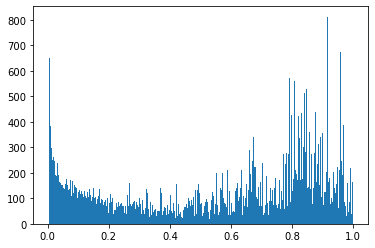

In [45]:
n = 10_000_000
take = 40000

weight = 1 / ((np.arange(n)**1.25)/(0.1*take)+1)
weight = weight/weight.sum()

sample = np.random.choice(n, take, p=weight, replace=False)
sample_arr = arr_sorted[sample]

_ = plt.hist(probability_arr[sample_arr[:,0][:num], sample_arr[:,1][:num]], bins=300)

In [47]:
import tqdm
for count, prediction in tqdm.tqdm_notebook(enumerate(arr_sorted[sample]), total=take):
    ligand_idx = prediction[0]
    target_idx = prediction[1]
    probability = probability_arr[ligand_idx][target_idx]
    
    try:
        if not pcv.has_ligand(ligand_idx):
            pcv.create_ligand(ligand_idx)
        
        if not pcv.has_target(target_idx):
            pcv.create_target(target_idx)
        
        if not pcv.has_prediction(ligand_idx, target_idx):
            pcv.create_prediction(ligand_idx, target_idx, probability)
        
    except KeyboardInterrupt:
        raise
    except Exception:
        pass
    
    if count>0 and count%1000==0:
        pcv.save_checkpoint()

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  
